### Creating Reidual, CLEAN, Synthesized Beam Maps

In the traditional radio astrnomy, the residual map, which is an inverse Fourier transform of the residual visibility, has been a very useful tool to check typical noise levels on the image. The CLEAN map, which is the sum of the (beam-convolved) model image and the residual map, is also a very popular image used as the final image of interferometric imaging. This notebook shows how we can compute the trasitional residual or CLEAN maps with SMILI. 

Note that once you selfcalibrate data, you can compute these maps for images obtained with closure imaging techniques as well.

In [1]:
%matplotlib inline
from pylab import *
from smili import uvdata, imdata, imaging, util

Here, we use a [VLBA data set of 3C345 at 43 GHz](./3C345MAR18.UVP) observed by the [Boston University Blazar Group](https://www.bu.edu/blazars/VLBAproject.html).

In [2]:
# Load uvfits file
uvfitsfile = "./3C345MAR18.UVP"
uvfits = uvdata.UVFITS(uvfitsfile).avspc()

# select stokes parameter
uvfits = uvfits.select_stokes("I")

# create a vistable
vtable = uvfits.make_vistable()

Filename: ./3C345MAR18.UVP
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 GroupsHDU      118   (3, 4, 1, 4, 1, 1)   float32   3014 Groups  7 Parameters
  1  AIPS NX       1 BinTableHDU     31   13R x 7C   [1E, 1E, 1J, 1J, 1J, 1J, 1J]   
  2  AIPS FQ       1 BinTableHDU     29   1R x 6C   [1J, 4D, 4E, 4E, 4J, 32A]   
  3  AIPS AN       1 BinTableHDU     72   9R x 14C   [8A, 3D, 0D, 1J, 1J, 1E, 1E, 4E, 1A, 1E, 8E, 1A, 1E, 8E]   

Loading HDUs in the input UVFITS files.
  Primary HDU was loaded.
  AIPS FQ Table was loaded.
  Subarray 1 was found in an AIPS AN table

Checking loaded HDUs.
  1 Subarray settings are found.
  No AIPS SU tables were found.
    Assuming that this is a single source UVFITS file.

Reading FQ Tables
  Frequency Setup ID: 1
    IF Freq setups (Hz):
         if_freq_offset  ch_bandwidth  if_bandwidth  sideband
      0             0.0    64000000.0    64000000.0         1
      1      80000000.0    64000000.0    64000000.0         

/Users/akiyama/anaconda/lib/python2.7/site-packages/astropy/io/fits/fitsrec.py:687: UserWarning: Field 'ORBPARM' has a repeat count of 0 in its format code, indicating an empty field.
  'indicating an empty field.'.format(key))


  Frequency Setup ID: 1
    Sources:
         id source                        radec  equinox
      0   1  3C345  16h42m58.81s +39d48m36.994s   2000.0

Reading Primary HDU data
  VisData.sort: 0 indexes have wrong station orders (ant1 > ant2).
  VisData.sort: Data have been sorted by utc, ant1, ant2, subarray
Stokes I data will be calculated from input RR and LL data


We can fit a beam size with vistable. errorweight means uvweighting using error. The default is errorweight=-2. The output will be a dictionary, which can be used to argments of convolution functions or gaussian functions.

In [3]:
beamprm = vtable.fit_beam(angunit="mas")
print(beamprm)

{u'minsize': 0.17205778821584752, u'pa': -19.757754393927826, u'majsize': 0.42634618969821364, u'angunit': 'mas'}


Let's create an image. Load the header information from uvfits files. After generating an image object, you can input the fitted beam parameter to the image. This will be used to compute "Jy/beam" for plotting, for instance. 

{'minsize': 0.1720577882158475, 'pa': -19.757754393927826, 'majsize': 0.42634618969821364, 'angunit': 'mas'}


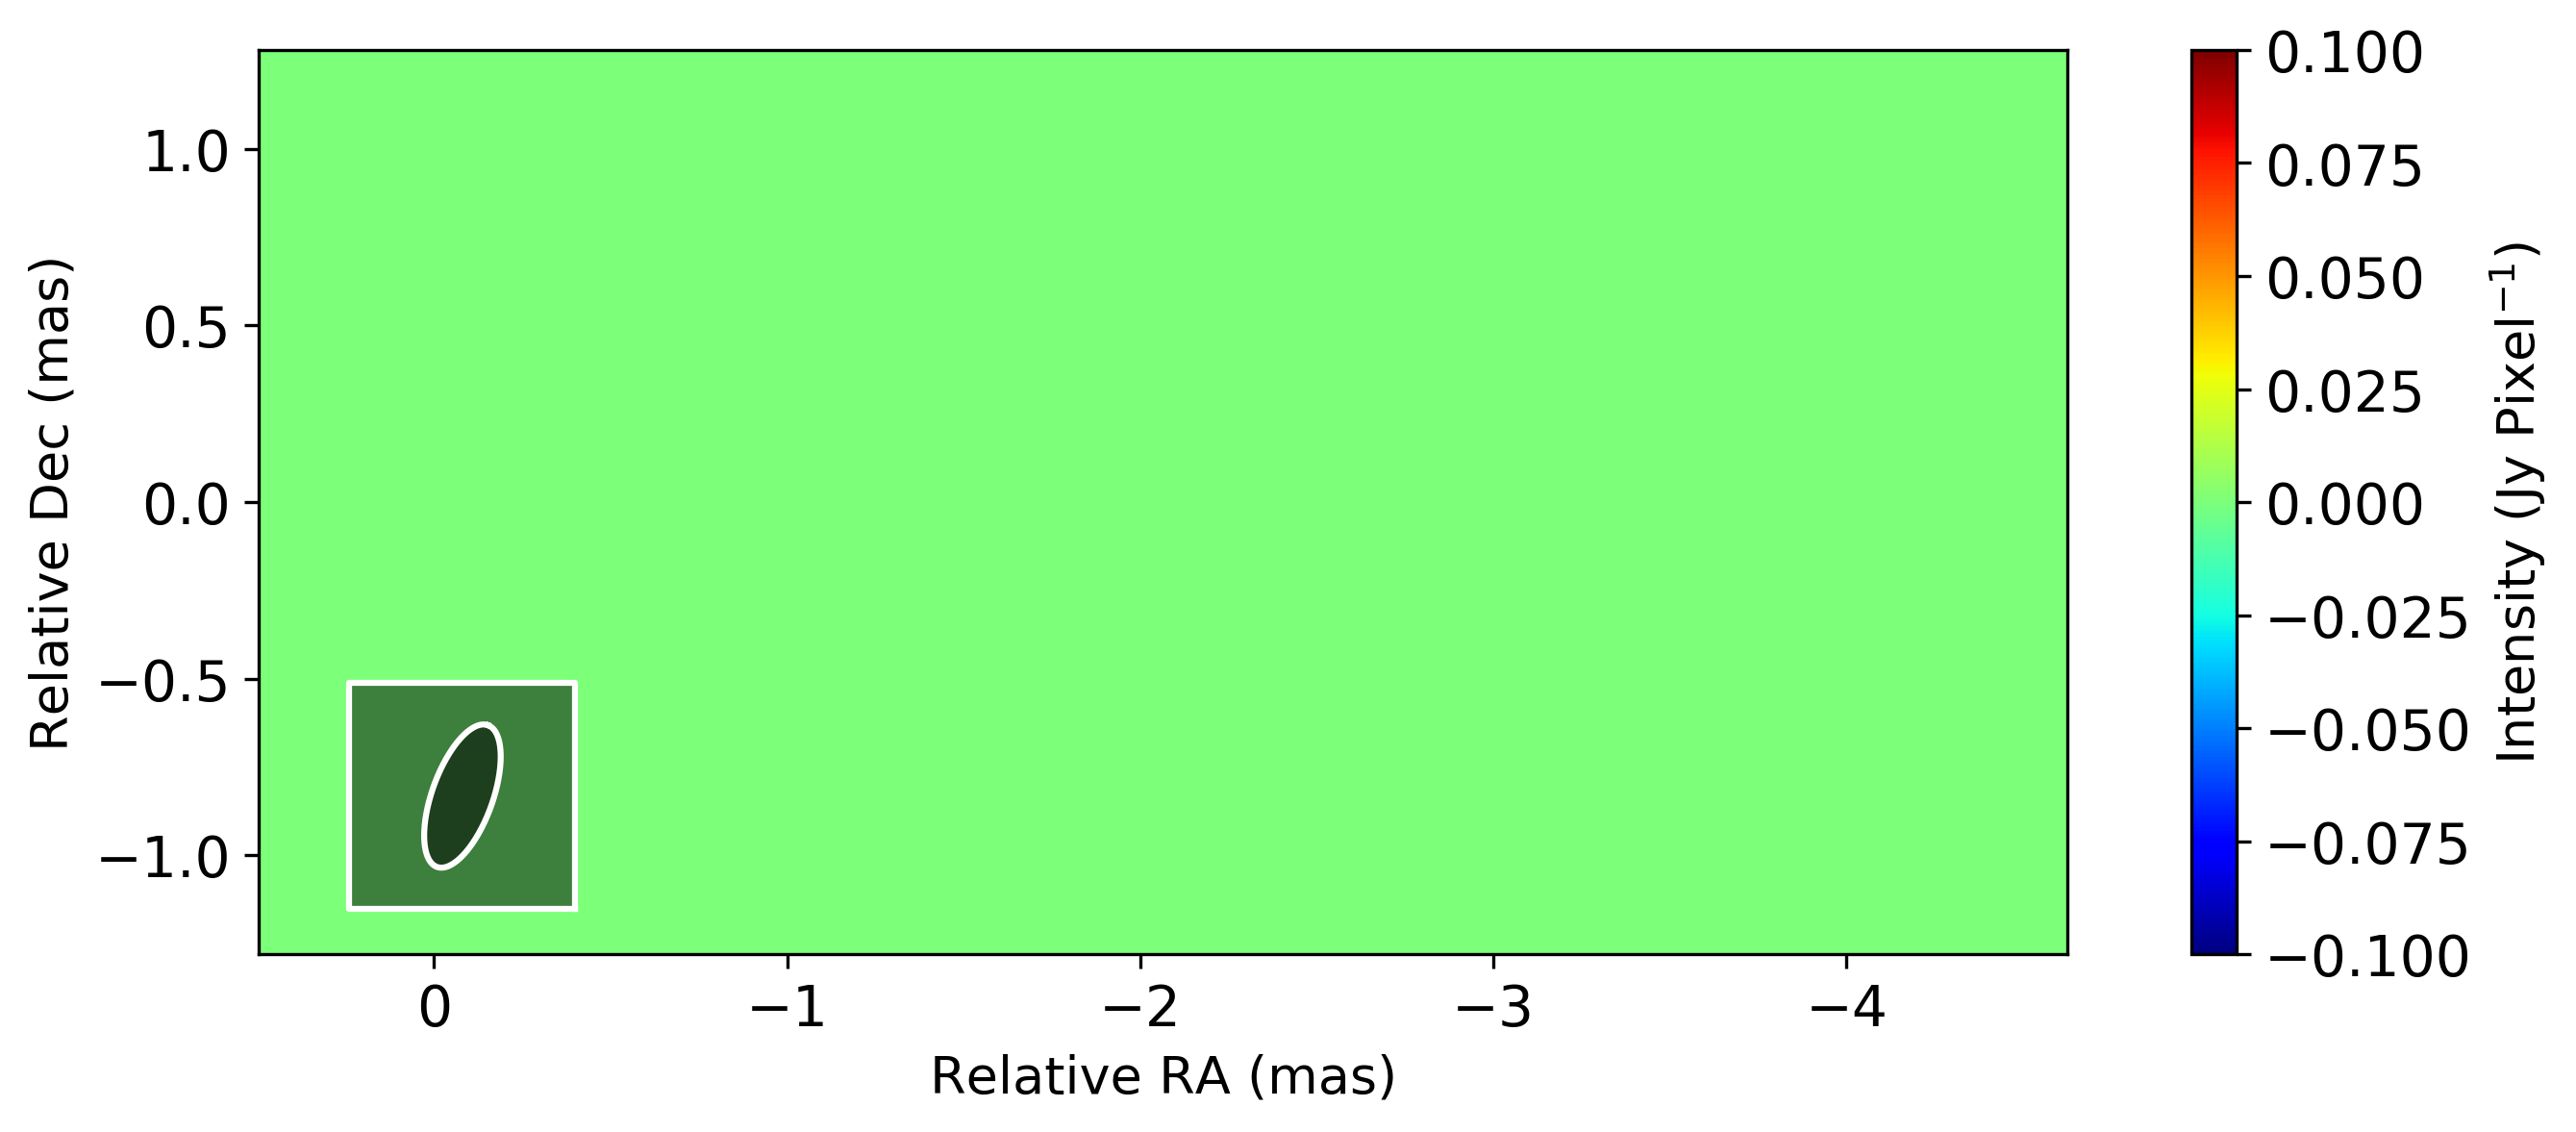

In [4]:
# create a blank image
initimage = imdata.IMFITS(nx=512, ny=256, nxref=50., dx=0.01, angunit="mas", uvfits=uvfitsfile)

# set a beam size for the unit conversion
initimage.set_beam(**beamprm)

# You can plot the beam with plot_beam method
util.matplotlibrc(width=800, height=300)
initimage.imshow(colorbar=True, cmap=cm.jet)
initimage.plot_beam()

# You can also get what is the current beam set in an image object
beamprm = initimage.get_beam()
print(beamprm)

You can make a synthesized beam with vtable.map_beam function.

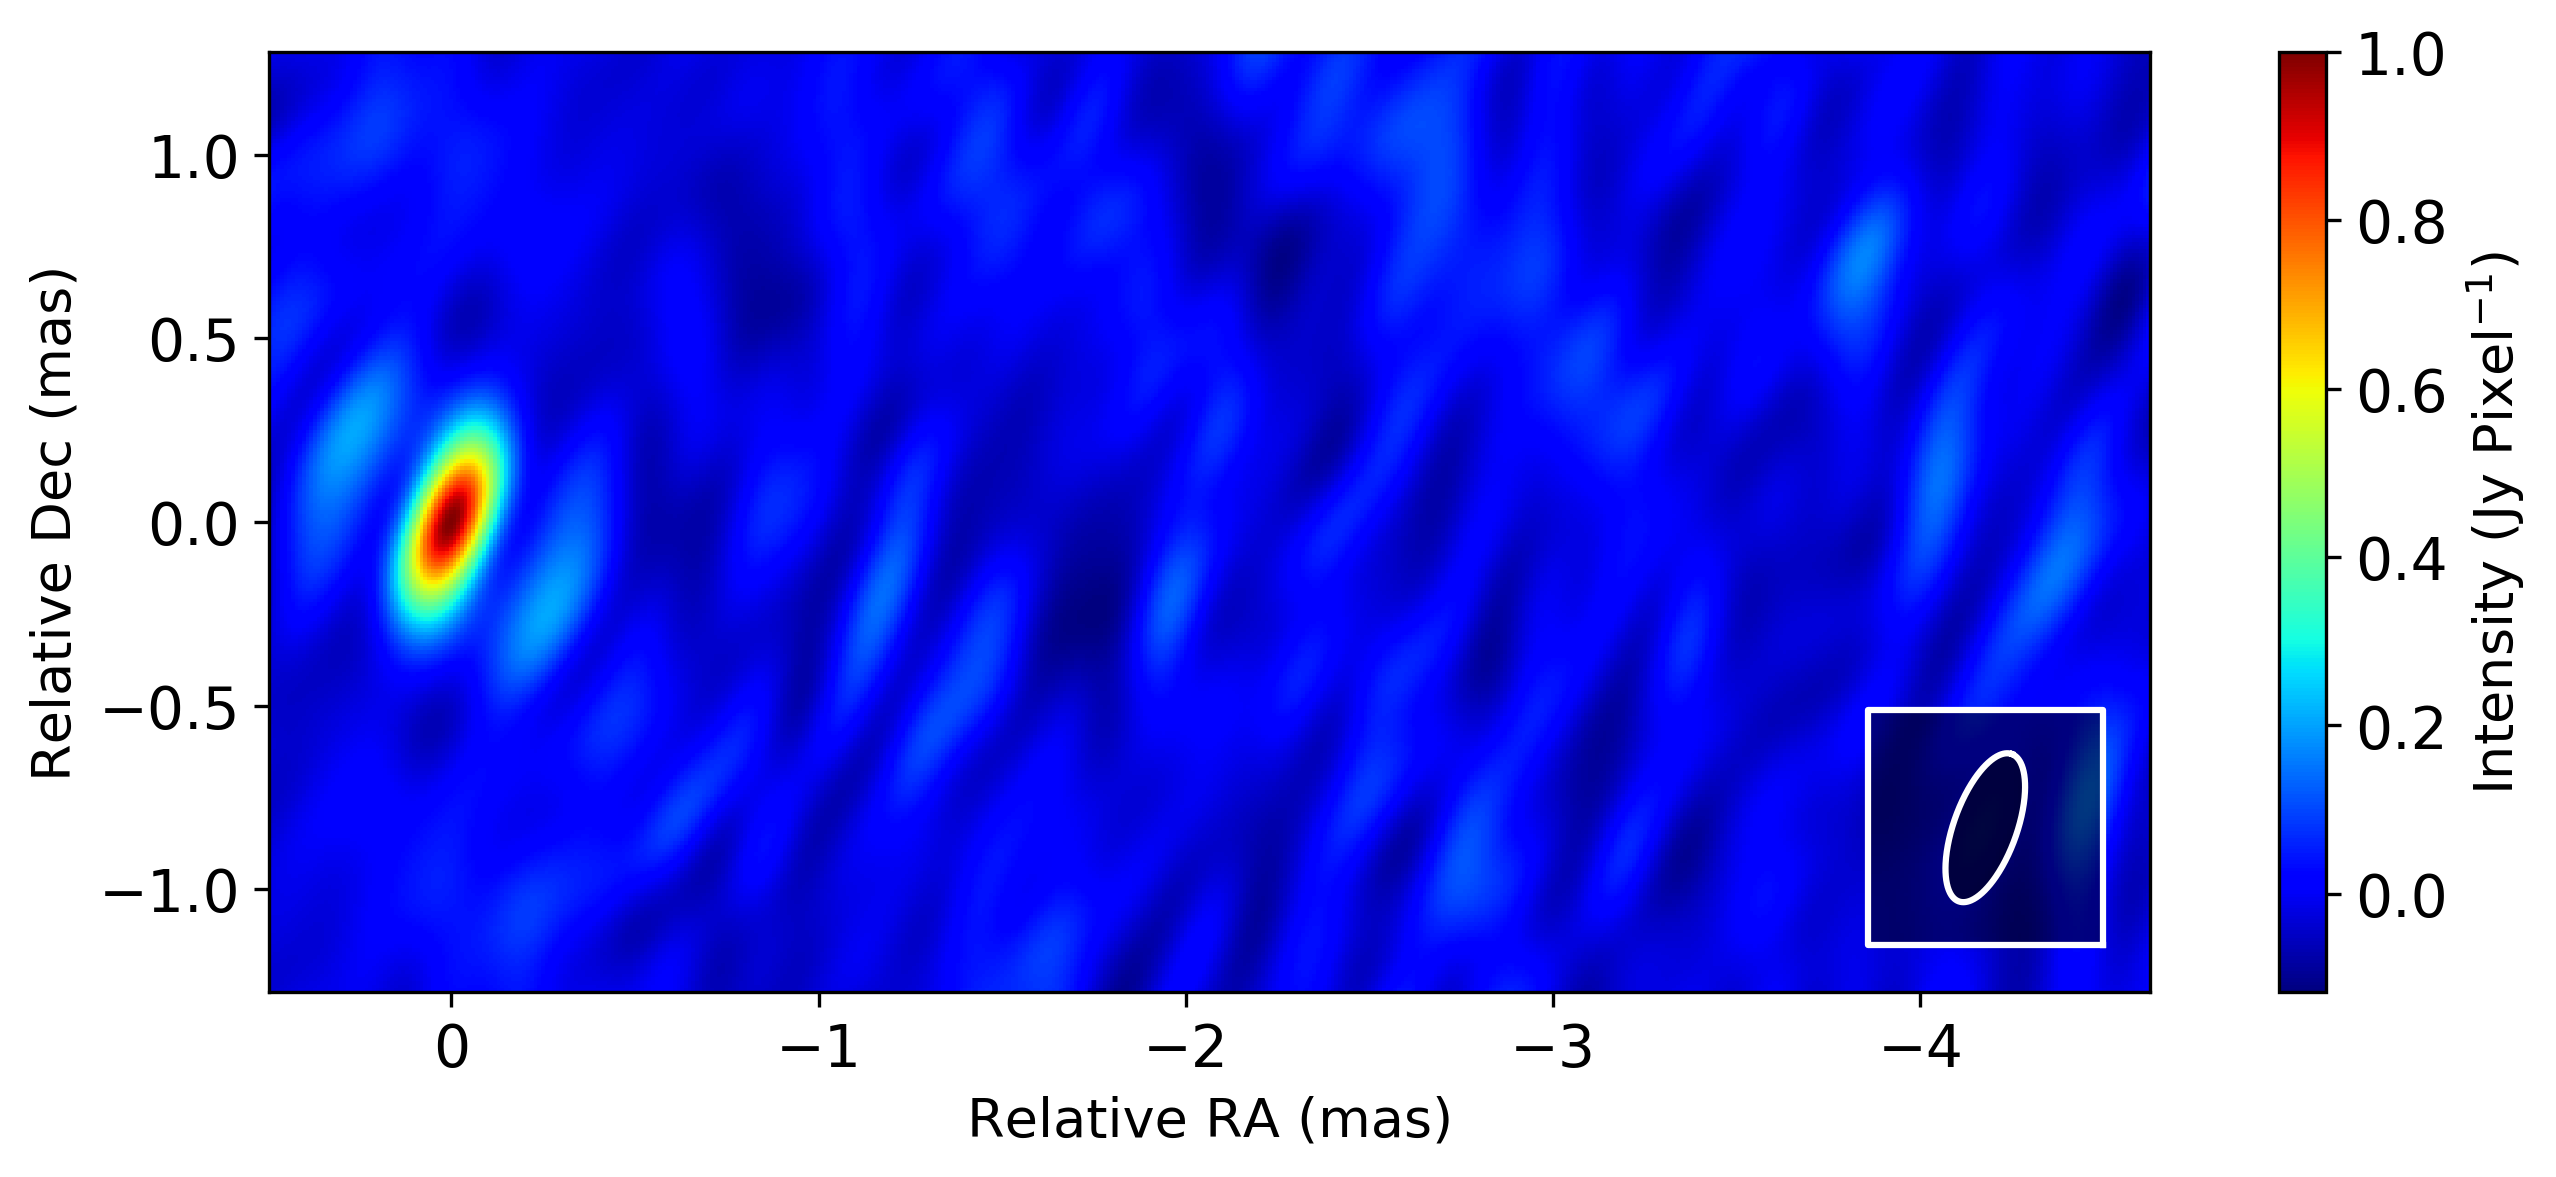

In [5]:
beam = vtable.map_beam(initimage, errorweight=-2)

util.matplotlibrc(width=800, height=300)
beam.imshow(colorbar=True, cmap=cm.jet)
beam.plot_beam(x0=0.85)

You can also make a dirty/residual map with vtable.map_residual function.

(<matplotlib.image.AxesImage at 0x1c27a00890>,
 <matplotlib.colorbar.Colorbar at 0x1c27990e50>)

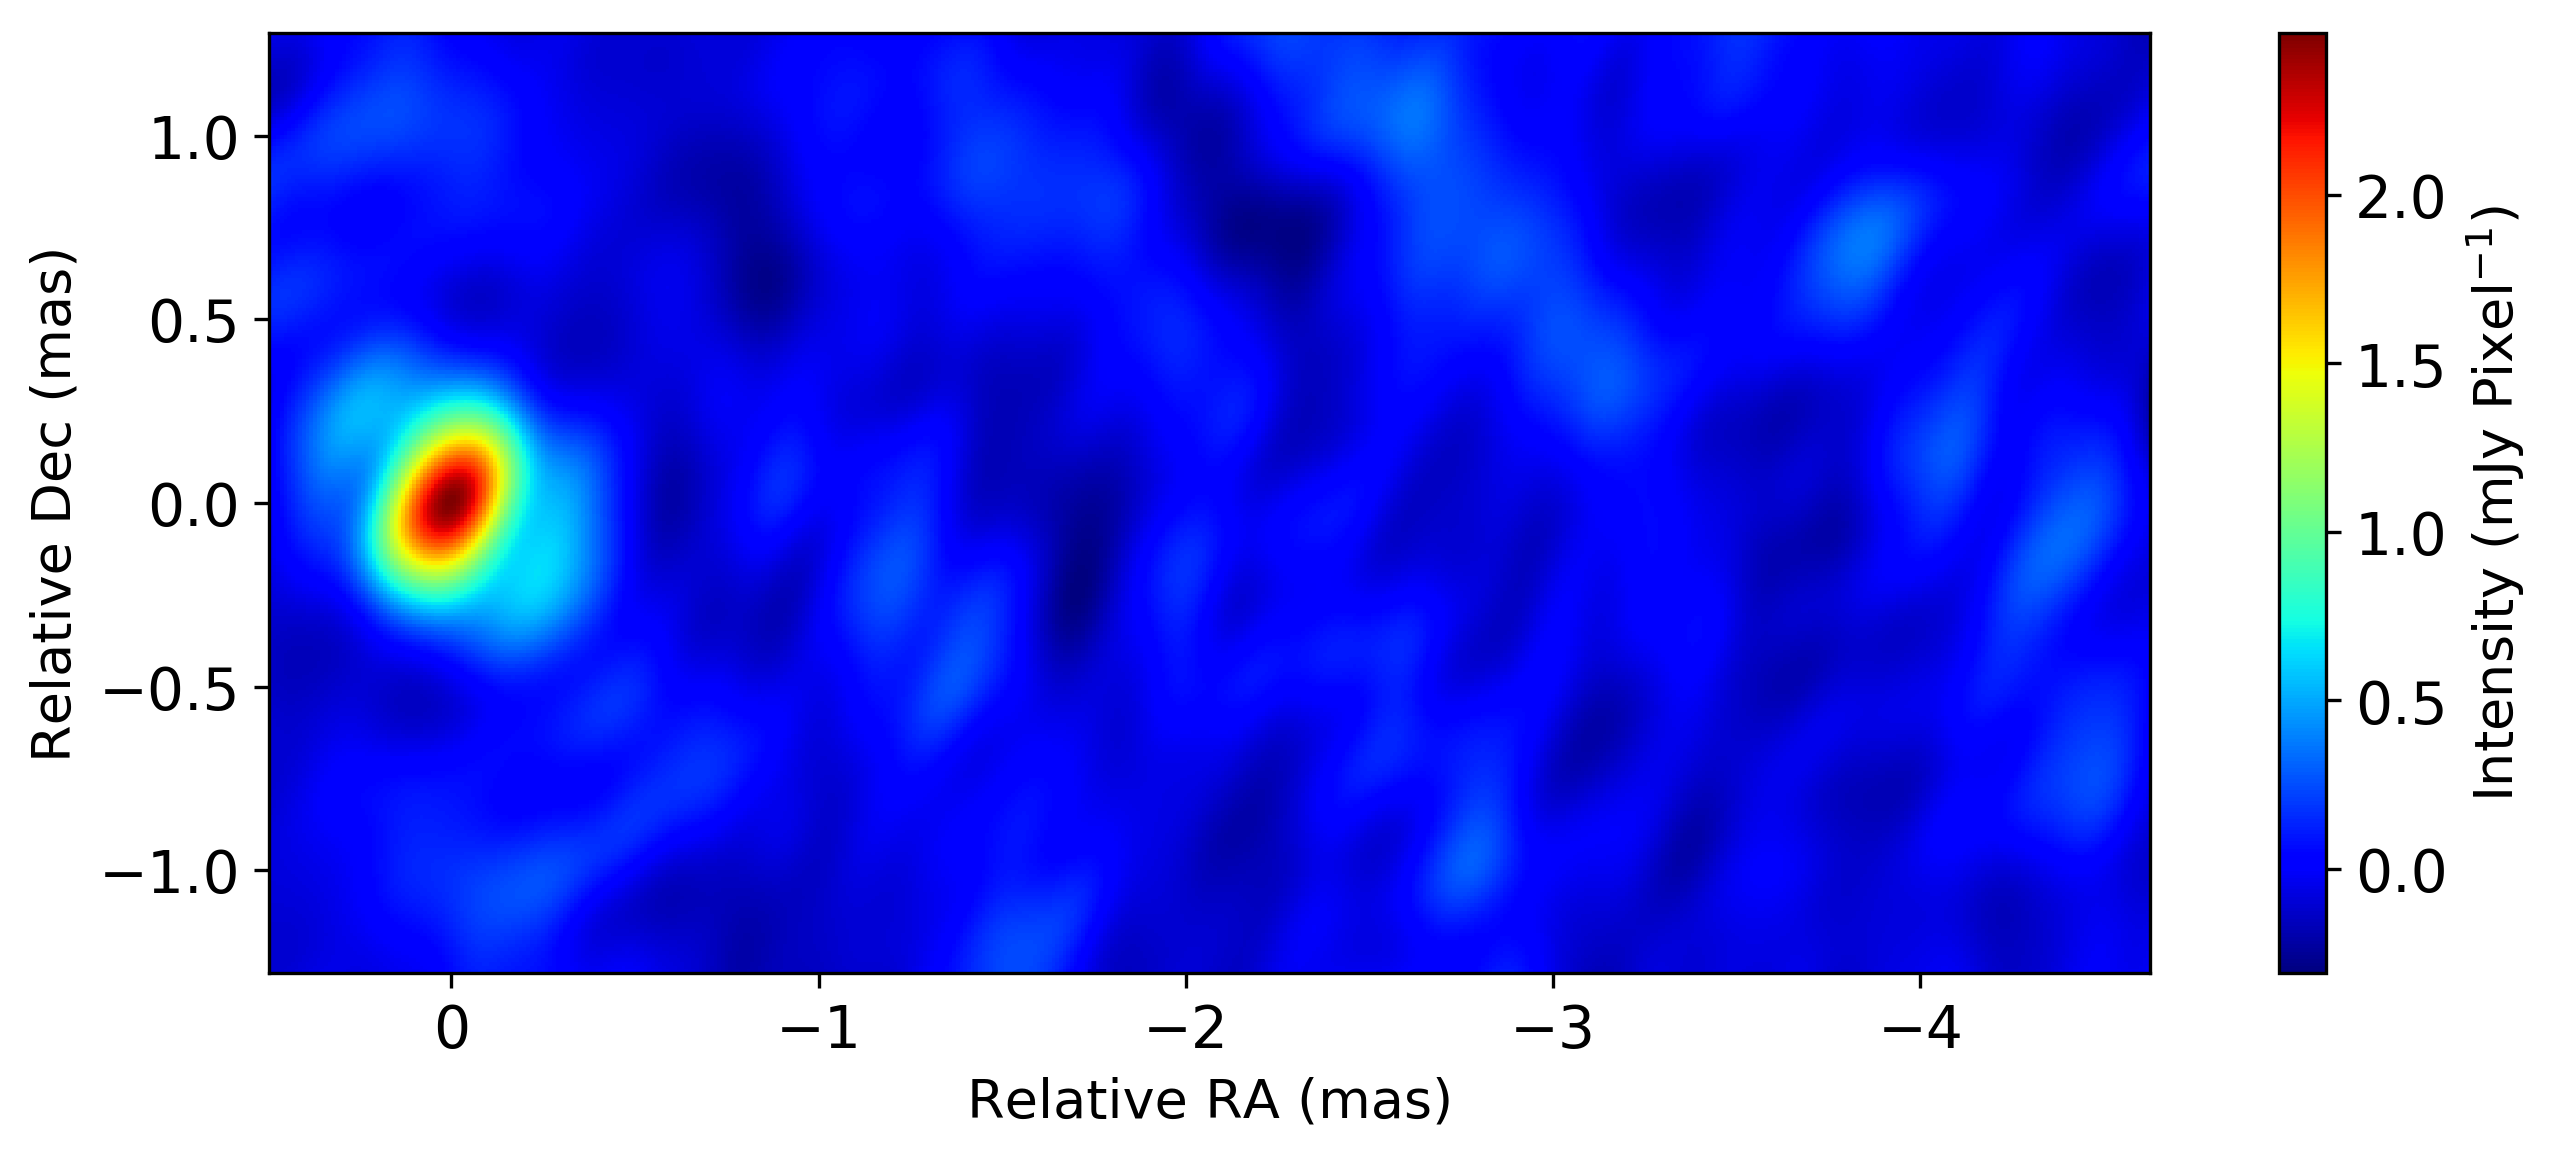

In [6]:
dmap = vtable.map_residual(initimage, errorweight=-2)

util.matplotlibrc(width=800, height=300)
dmap.imshow(colorbar=True, fluxunit="mjy", cmap=cm.jet)

Let's start imaging. Here, we just quickly image data.

In [7]:
outimage = imaging.lbfgs.imaging(
    initimage,
    vistable = vtable,
    lambl1=1.0,
    lambtsv=0.1,
    niter=1000
)

Imaging Window: Not Specified. We solve the image on all the pixels.
Total Flux Constraint: disabled.


(<matplotlib.image.AxesImage at 0x1c27c430d0>,
 <matplotlib.colorbar.Colorbar at 0x1c27c79650>)

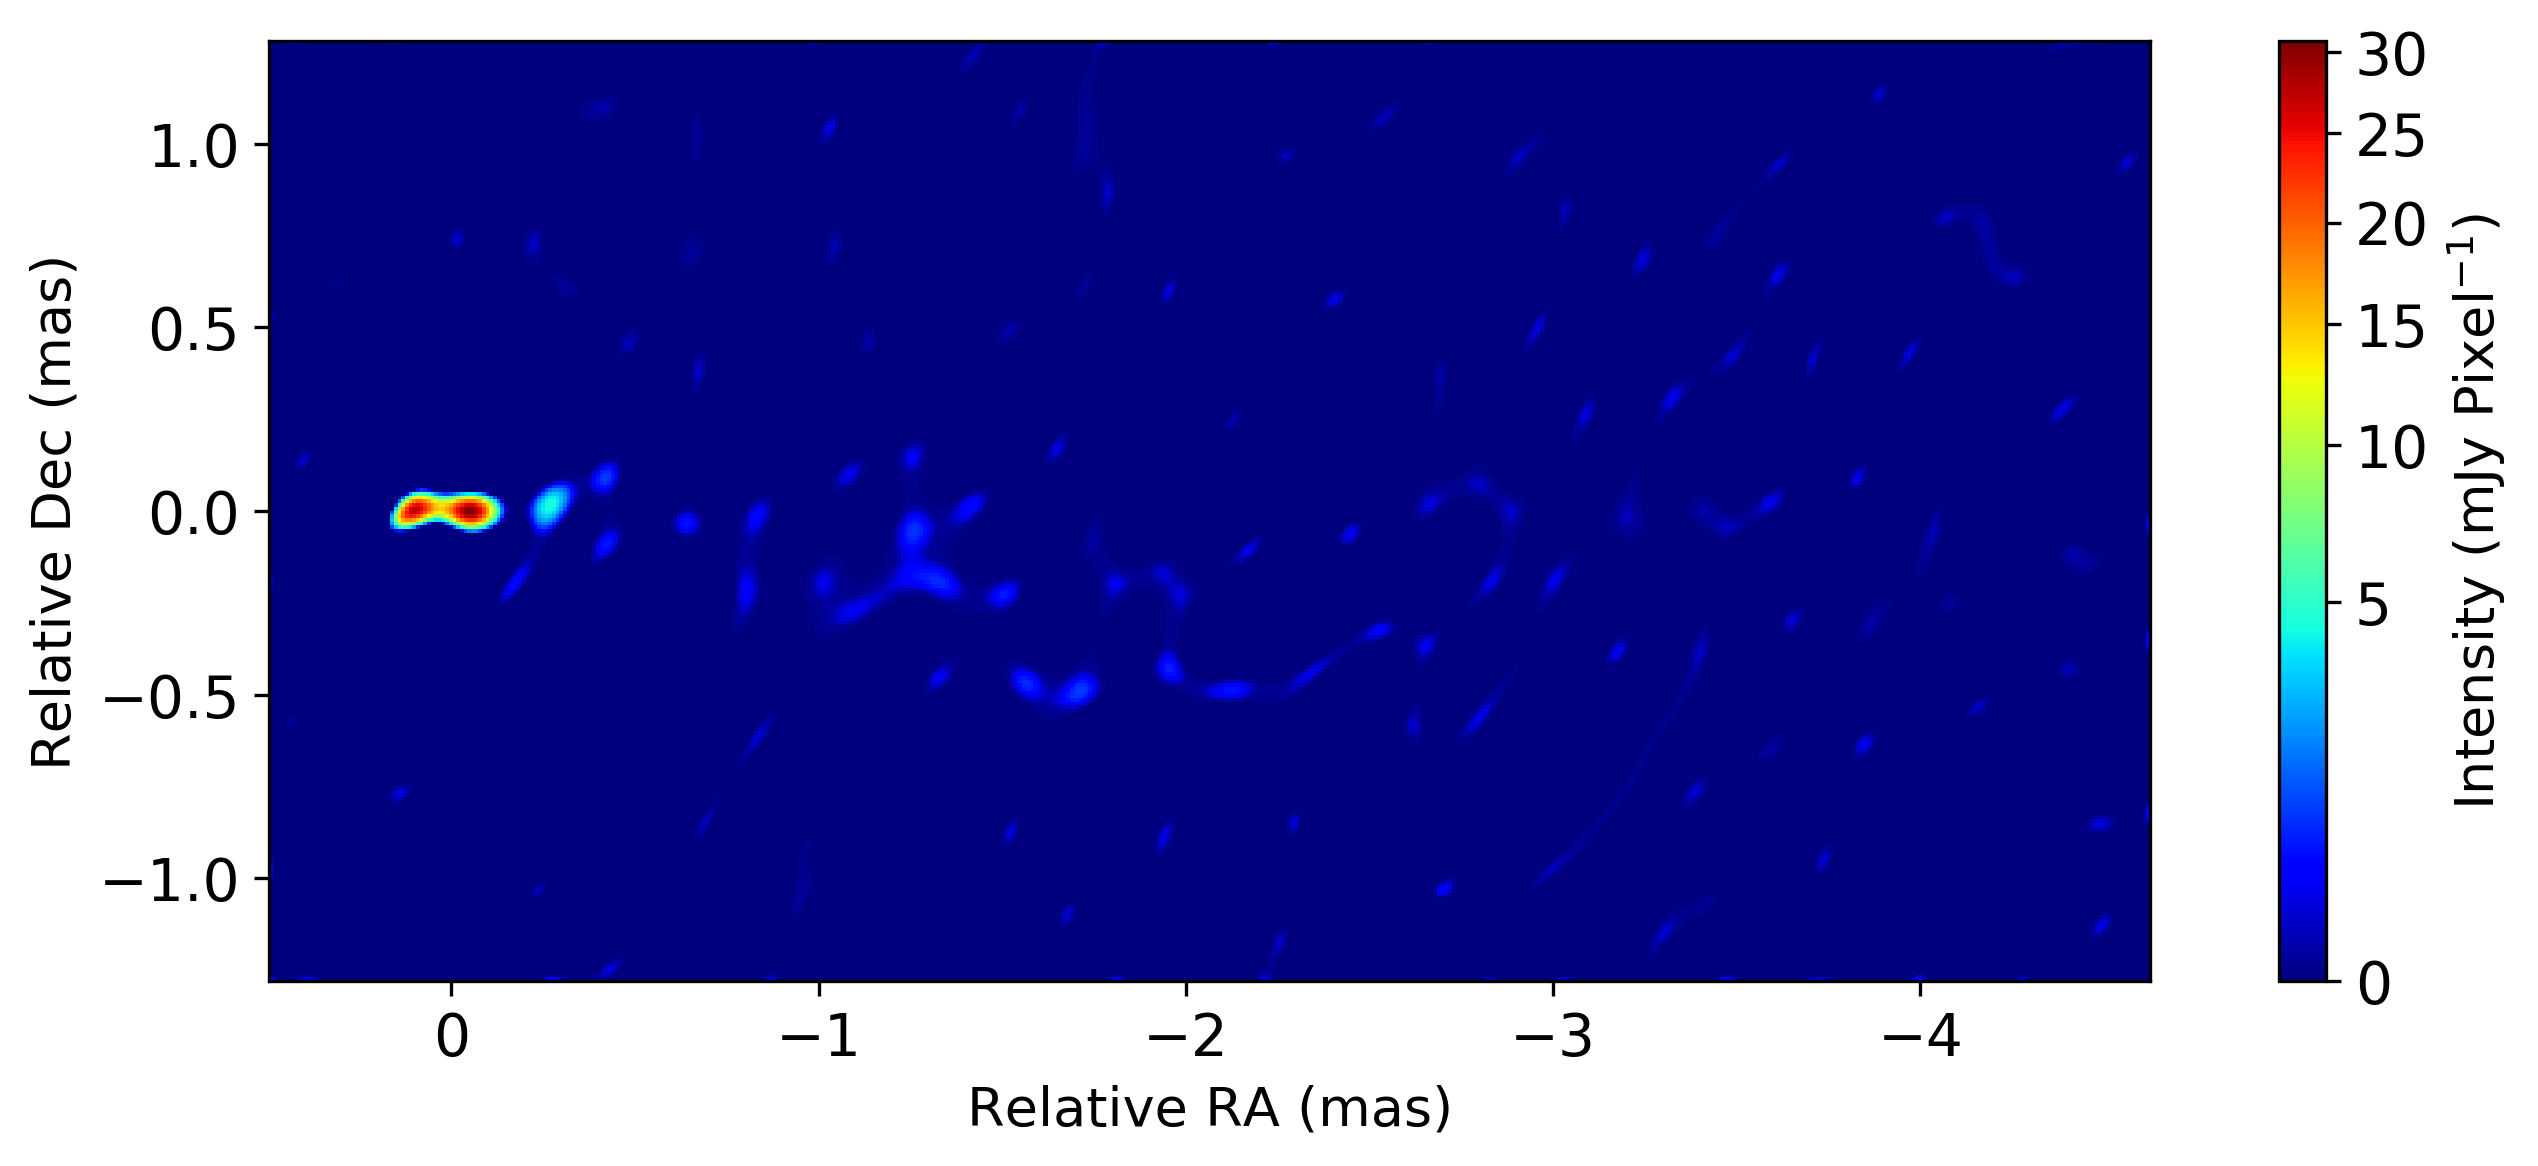

In [8]:
util.matplotlibrc(width=800, height=300)
outimage.imshow(colorbar=True, fluxunit="mjy", scale="gamma", cmap=cm.jet)

You can plot a residual map.

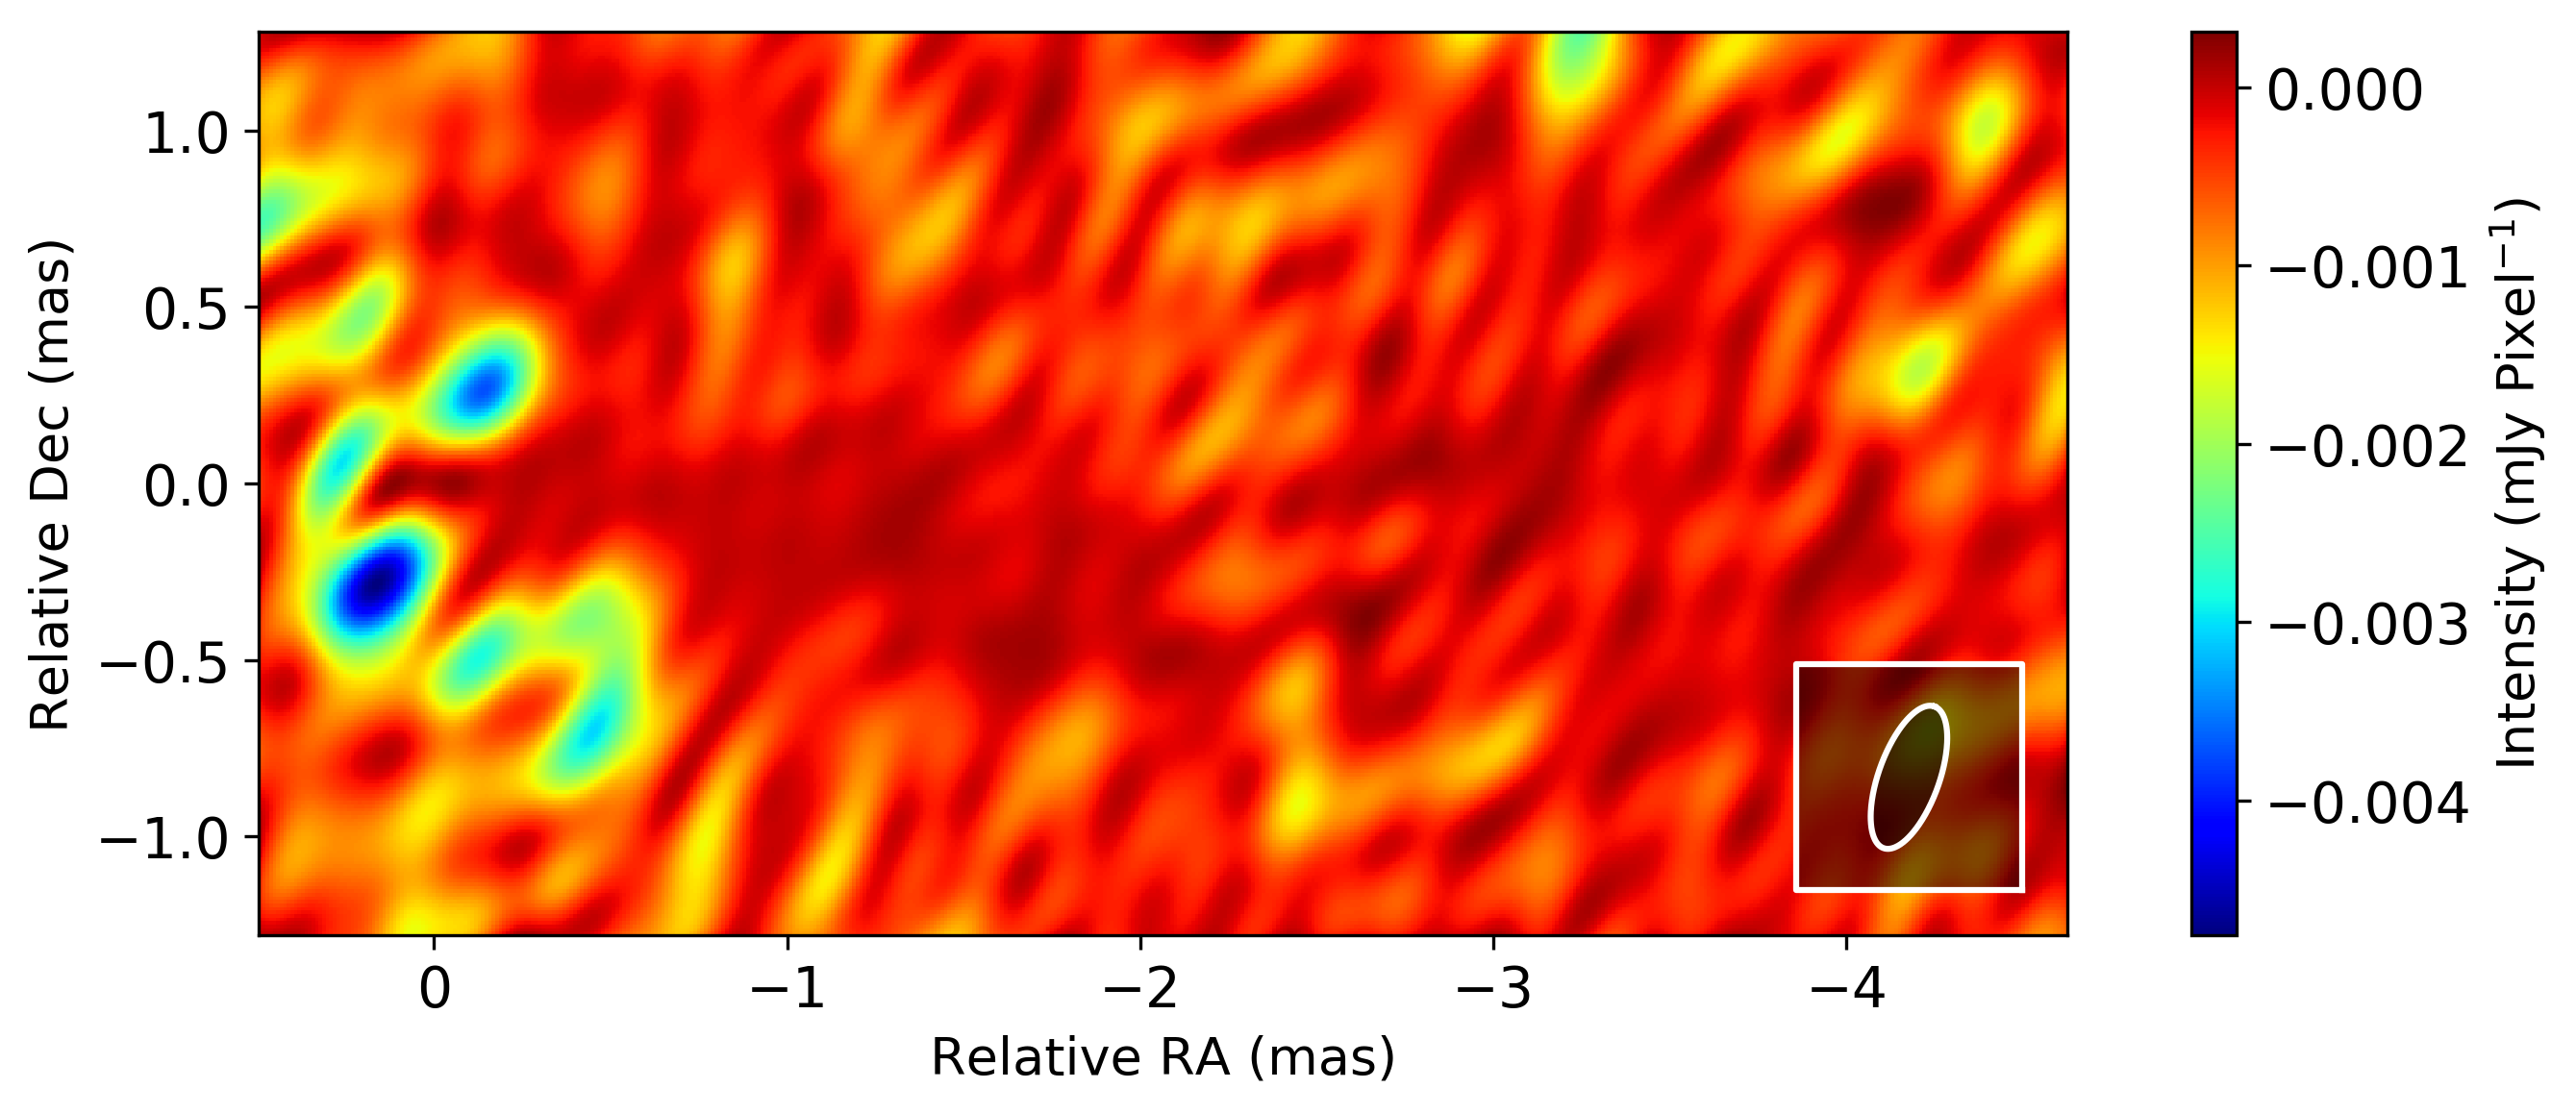

In [9]:
resid = vtable.map_residual(outimage, errorweight=-2)

util.matplotlibrc(width=800, height=300)
resid.imshow(colorbar=True,  fluxunit="mjy", saunit="pixel", cmap=cm.jet)
resid.plot_beam(x0=0.85)

You can also compute a clean map. If you use restore=True, the model image will be convolved before adding residual map. Otherwise it will compute model+residual map

/Users/akiyama/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'ls'
  s)


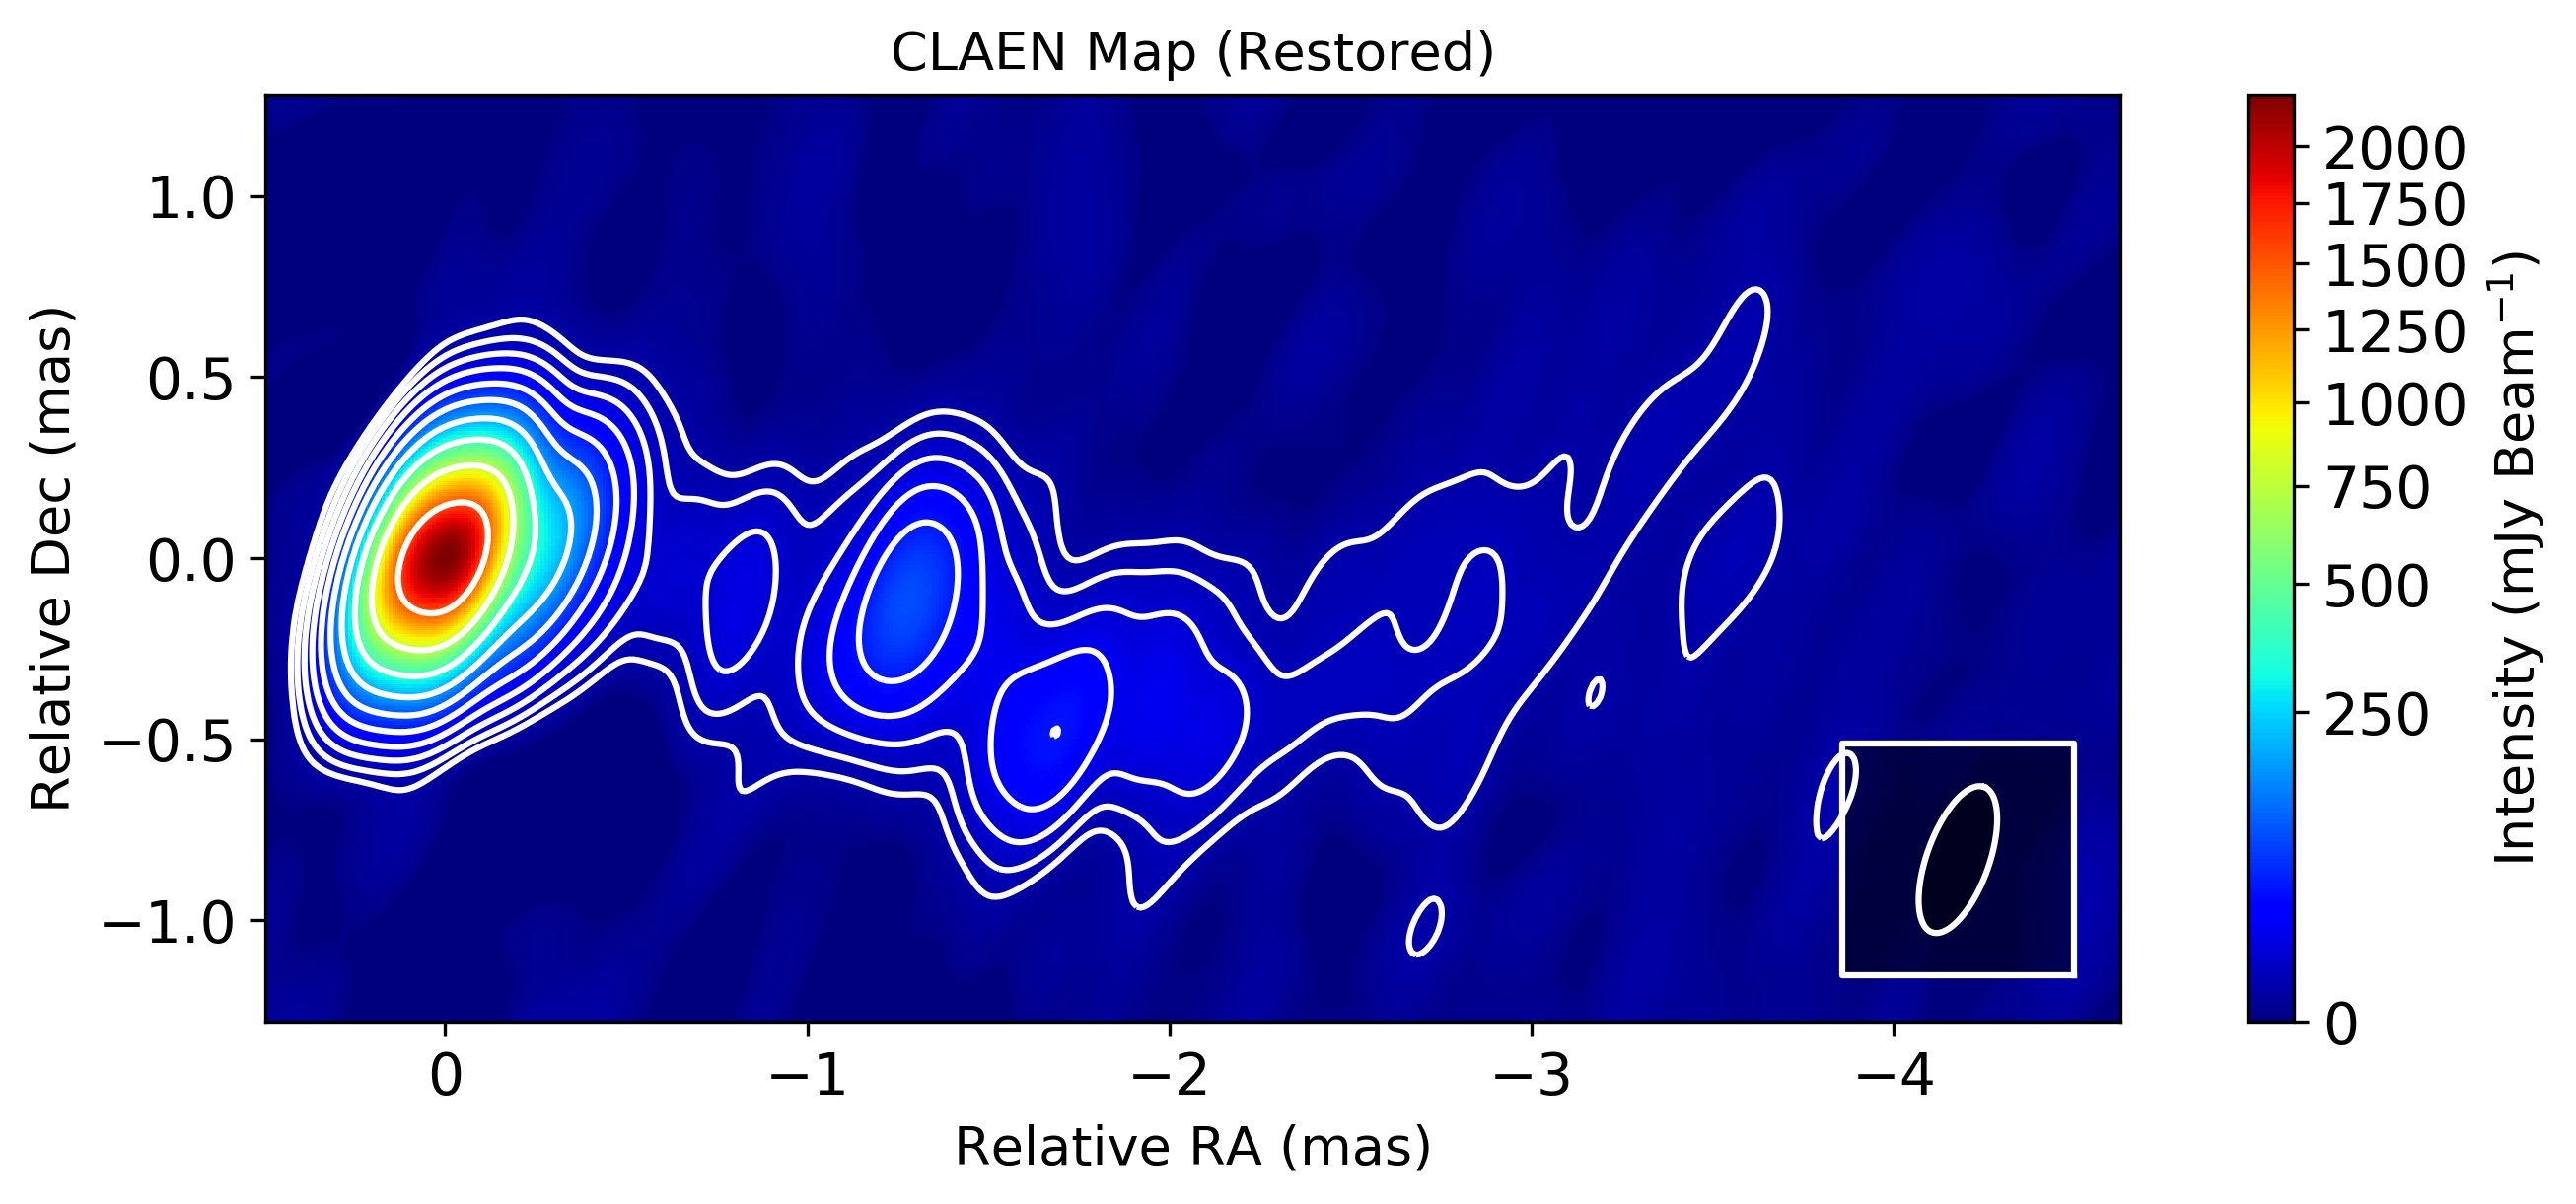

In [10]:
clean = vtable.map_clean(outimage, restore=True, errorweight=-2)

# check dynamic range
rms = resid.rms(fluxunit="Jy", saunit="pixel")
peak = clean.peak(fluxunit="Jy", saunit="pixel")
dyrange = peak/rms

# plot
plt.title("CLAEN Map (Restored)")
clean.imshow(scale="gamma", colorbar=True, fluxunit="mjy", saunit="beam", cmap=cm.jet)
clean.contour(cmul=5/dyrange, relative=True)
clean.plot_beam(x0=0.85)

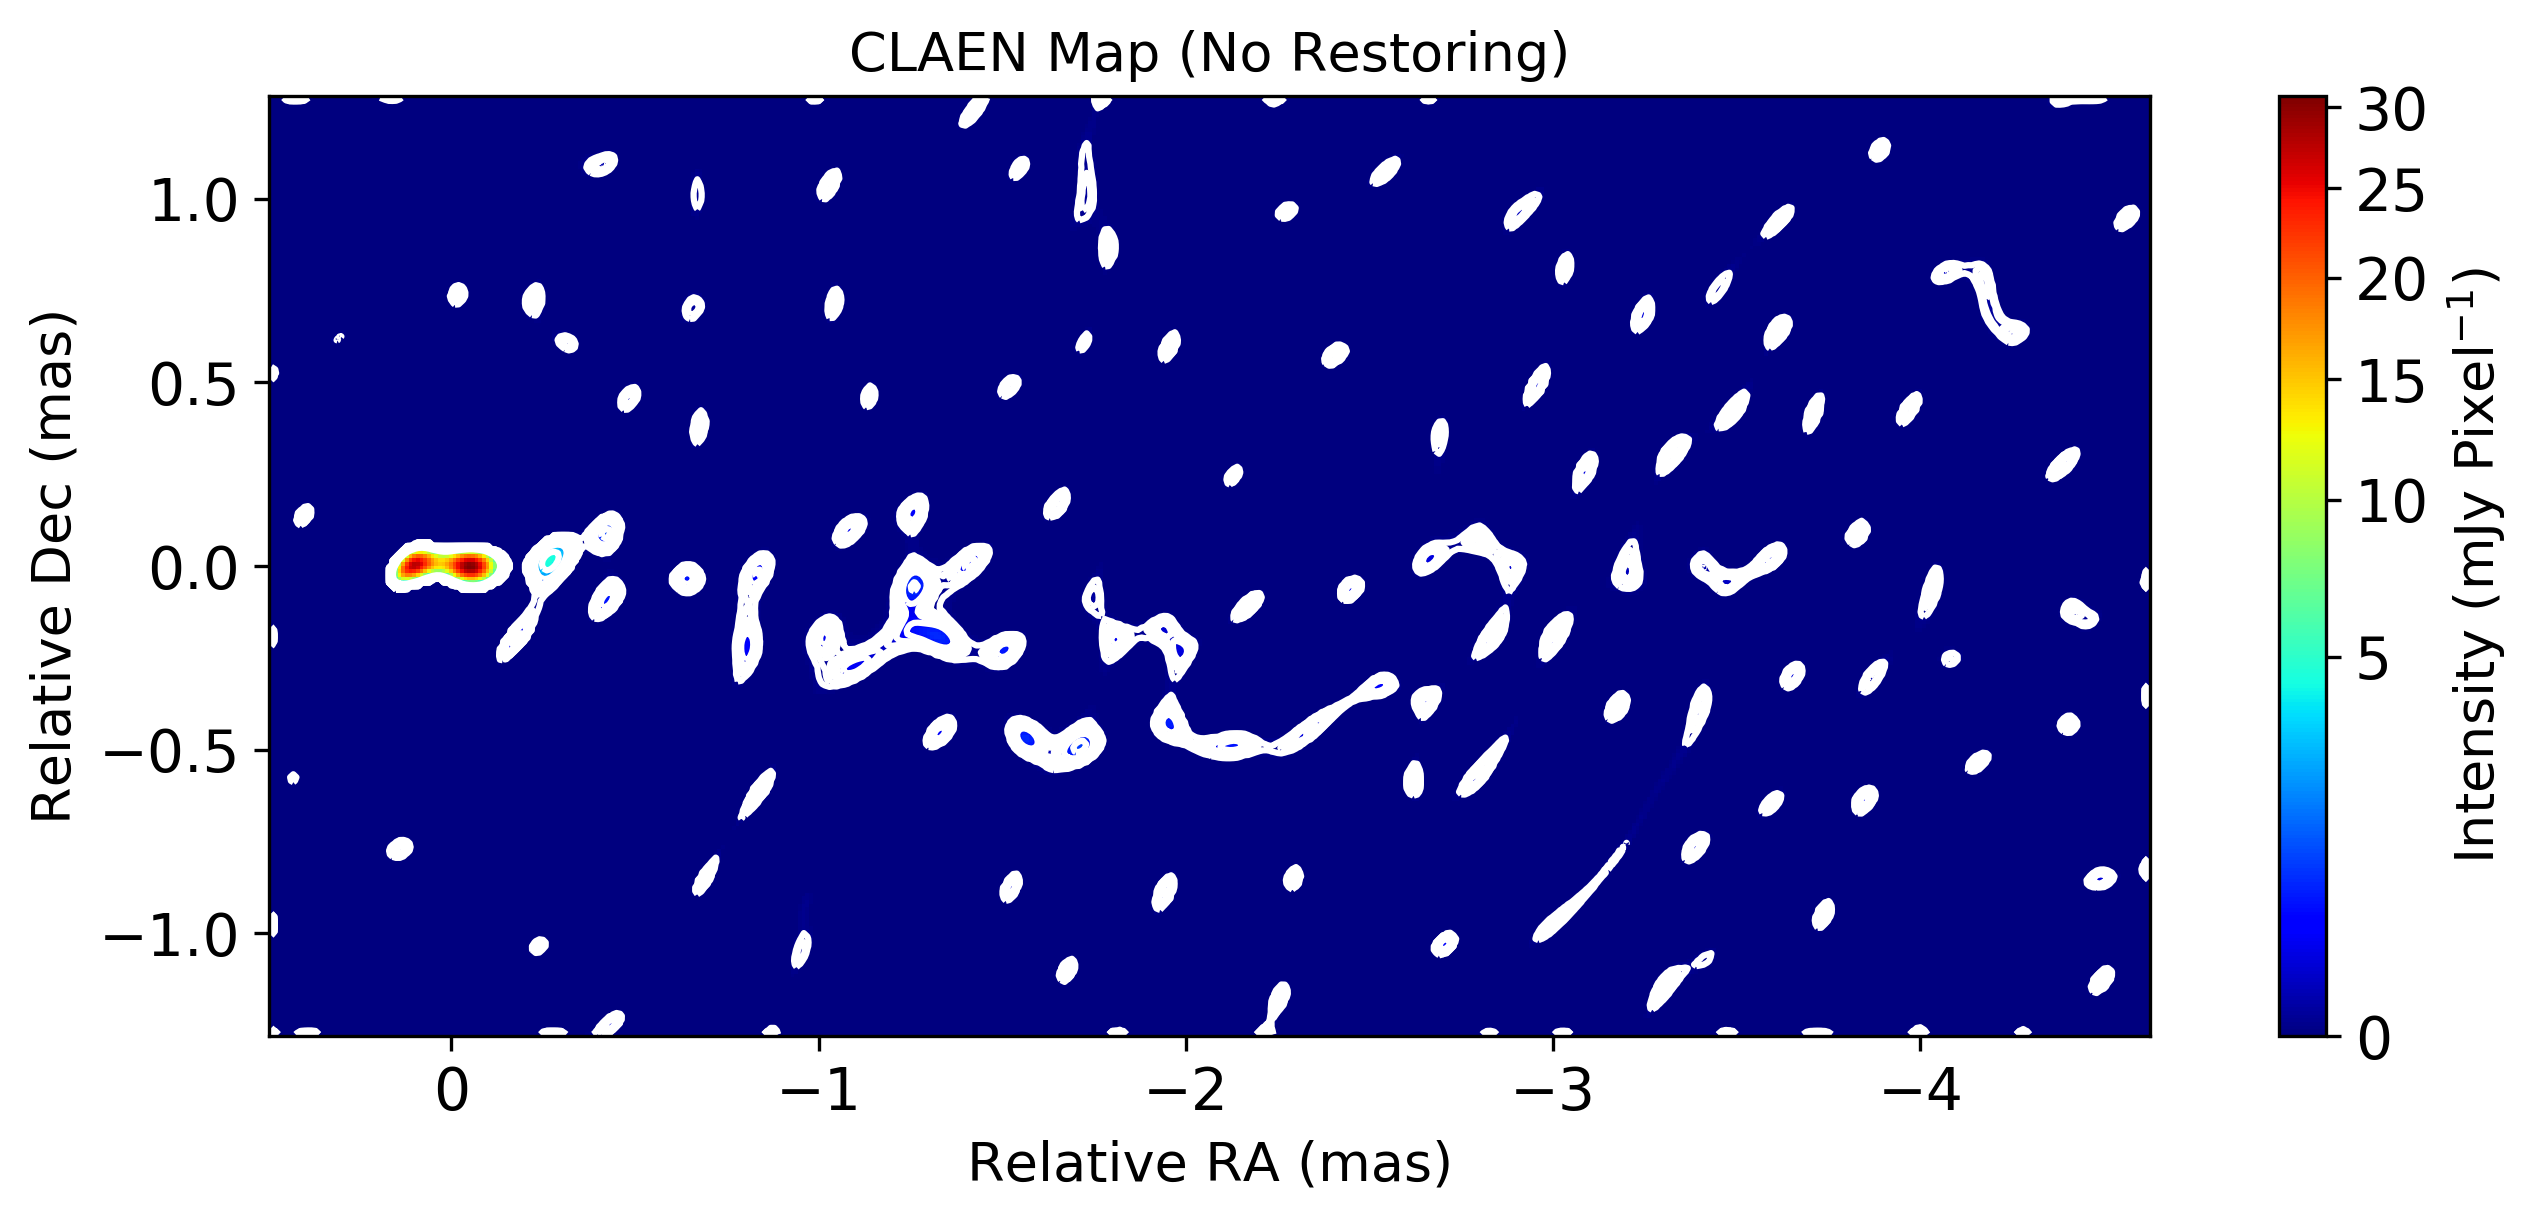

In [11]:
clean = vtable.map_clean(outimage, restore=False, errorweight=-2)

# check dynamic range
rms = resid.rms(fluxunit="Jy", saunit="pixel")
peak = clean.peak(fluxunit="Jy", saunit="pixel")
dyrange = peak/rms

# plot
plt.title("CLAEN Map (No Restoring)")
clean.imshow(scale="gamma", colorbar=True, fluxunit="mjy", cmap=cm.jet)
clean.contour(cmul=10/dyrange, relative=True)

How you can compute the dynamic range? You can compute it with IMFITS.rms() method.

In [12]:
rms = resid.rms(fluxunit="Jy", saunit="pixel")
peak = clean.peak(fluxunit="Jy", saunit="pixel")
dyrange = peak/rms
print(rms, peak, dyrange)

(7.132424174887726e-07, 0.030730492863073656, 43085.62153562242)


Since there is a big residual due to selfcal with CLEAN in the original uvfits file, we should probably selfcal data. Here, we quickly selfcal data and re-image data again.

In [13]:
uvfits = uvdata.UVFITS(uvfitsfile).avspc().select_stokes("I")

# selfcal for 5 times
for i in xrange(5):
    # selfcalibration (g)
    cltable = uvfits.selfcal(outimage).rescale()
    uvfits = uvfits.apply_cltable(cltable)

    # re-create uvfits file
    vtable = uvfits.make_vistable()

    # re-imaging
    outimage = imaging.lbfgs.imaging(
        outimage,
        vistable = vtable,
        lambl1=1,
        lambtsv=1.0,
        niter=1000
    )

Filename: ./3C345MAR18.UVP
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 GroupsHDU      118   (3, 4, 1, 4, 1, 1)   float32   3014 Groups  7 Parameters
  1  AIPS NX       1 BinTableHDU     31   13R x 7C   [1E, 1E, 1J, 1J, 1J, 1J, 1J]   
  2  AIPS FQ       1 BinTableHDU     29   1R x 6C   [1J, 4D, 4E, 4E, 4J, 32A]   
  3  AIPS AN       1 BinTableHDU     72   9R x 14C   [8A, 3D, 0D, 1J, 1J, 1E, 1E, 4E, 1A, 1E, 8E, 1A, 1E, 8E]   

Loading HDUs in the input UVFITS files.
  Primary HDU was loaded.
  AIPS FQ Table was loaded.
  Subarray 1 was found in an AIPS AN table

Checking loaded HDUs.
  1 Subarray settings are found.
  No AIPS SU tables were found.
    Assuming that this is a single source UVFITS file.

Reading FQ Tables
  Frequency Setup ID: 1
    IF Freq setups (Hz):
         if_freq_offset  ch_bandwidth  if_bandwidth  sideband
      0             0.0    64000000.0    64000000.0         1
      1      80000000.0    64000000.0    64000000.0         

19it [00:00, 189.80it/s]

Subarray 1


100it [00:00, 166.93it/s]


1.0002655774471616
Imaging Window: Not Specified. We solve the image on all the pixels.
Total Flux Constraint: disabled.


15it [00:00, 143.20it/s]

Initialize CL Table
Compute Model Visibilities
Subarray 1


100it [00:00, 163.36it/s]


1.0005838142464172
Imaging Window: Not Specified. We solve the image on all the pixels.
Total Flux Constraint: disabled.


18it [00:00, 171.44it/s]

Initialize CL Table
Compute Model Visibilities
Subarray 1


100it [00:00, 164.71it/s]


1.000518746004462
Imaging Window: Not Specified. We solve the image on all the pixels.
Total Flux Constraint: disabled.


20it [00:00, 192.22it/s]

Initialize CL Table
Compute Model Visibilities
Subarray 1


100it [00:00, 151.65it/s]


1.0004574416234047
Imaging Window: Not Specified. We solve the image on all the pixels.
Total Flux Constraint: disabled.


22it [00:00, 219.06it/s]

Initialize CL Table
Compute Model Visibilities
Subarray 1


100it [00:00, 173.61it/s]


1.000418010387839
Imaging Window: Not Specified. We solve the image on all the pixels.
Total Flux Constraint: disabled.


Let's check maps. 

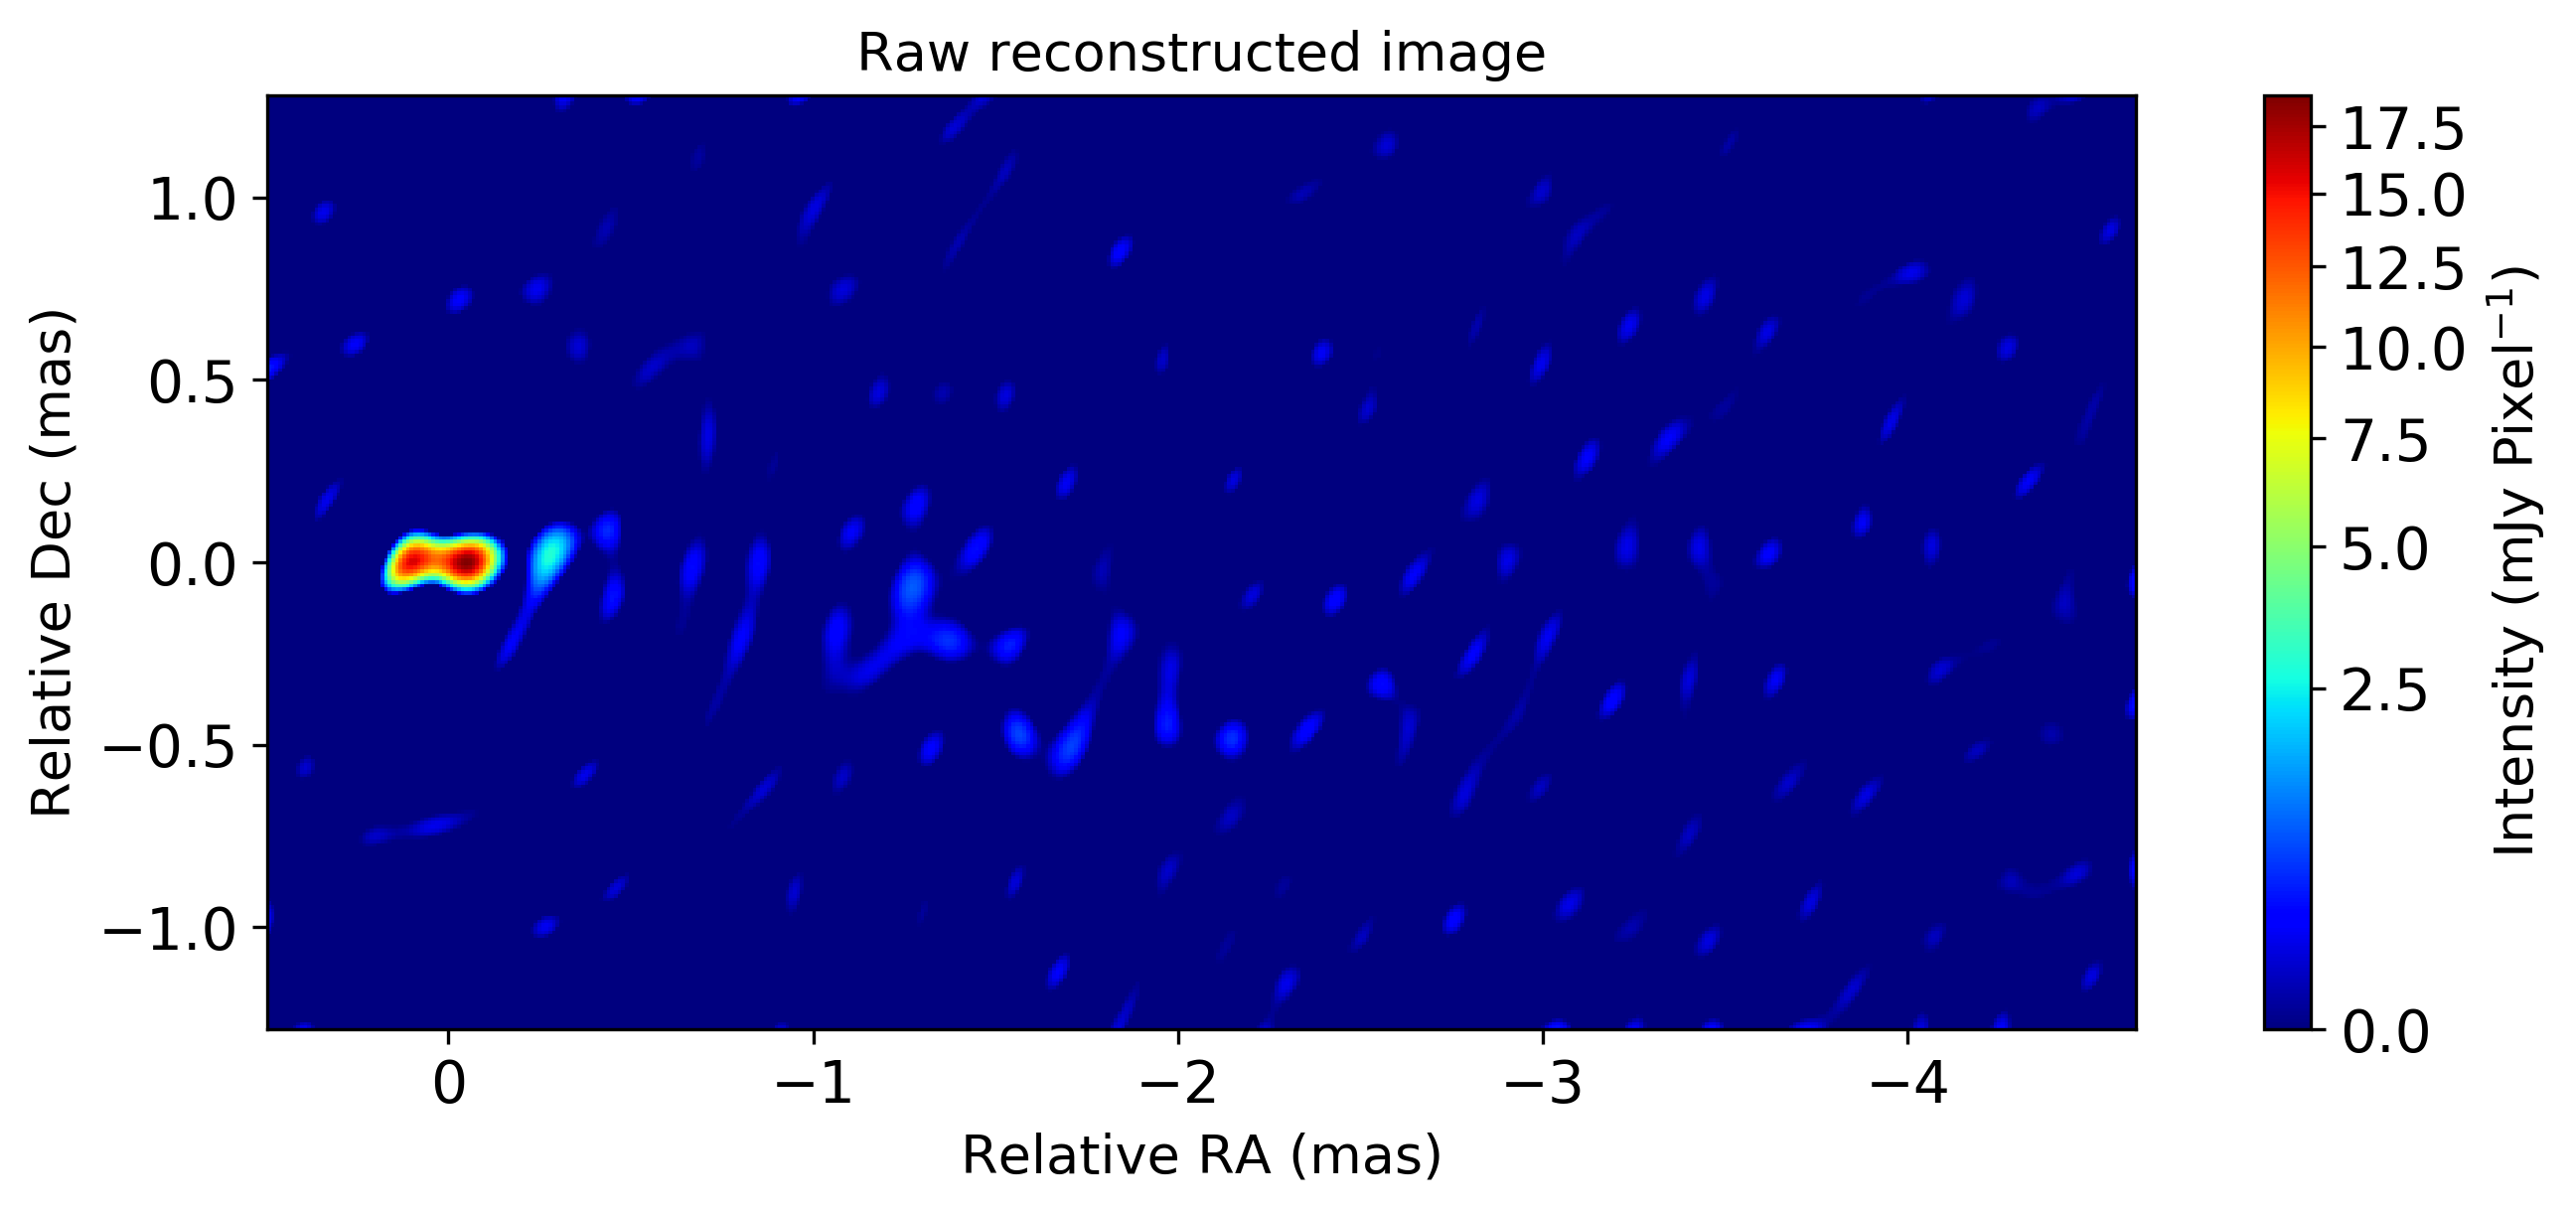

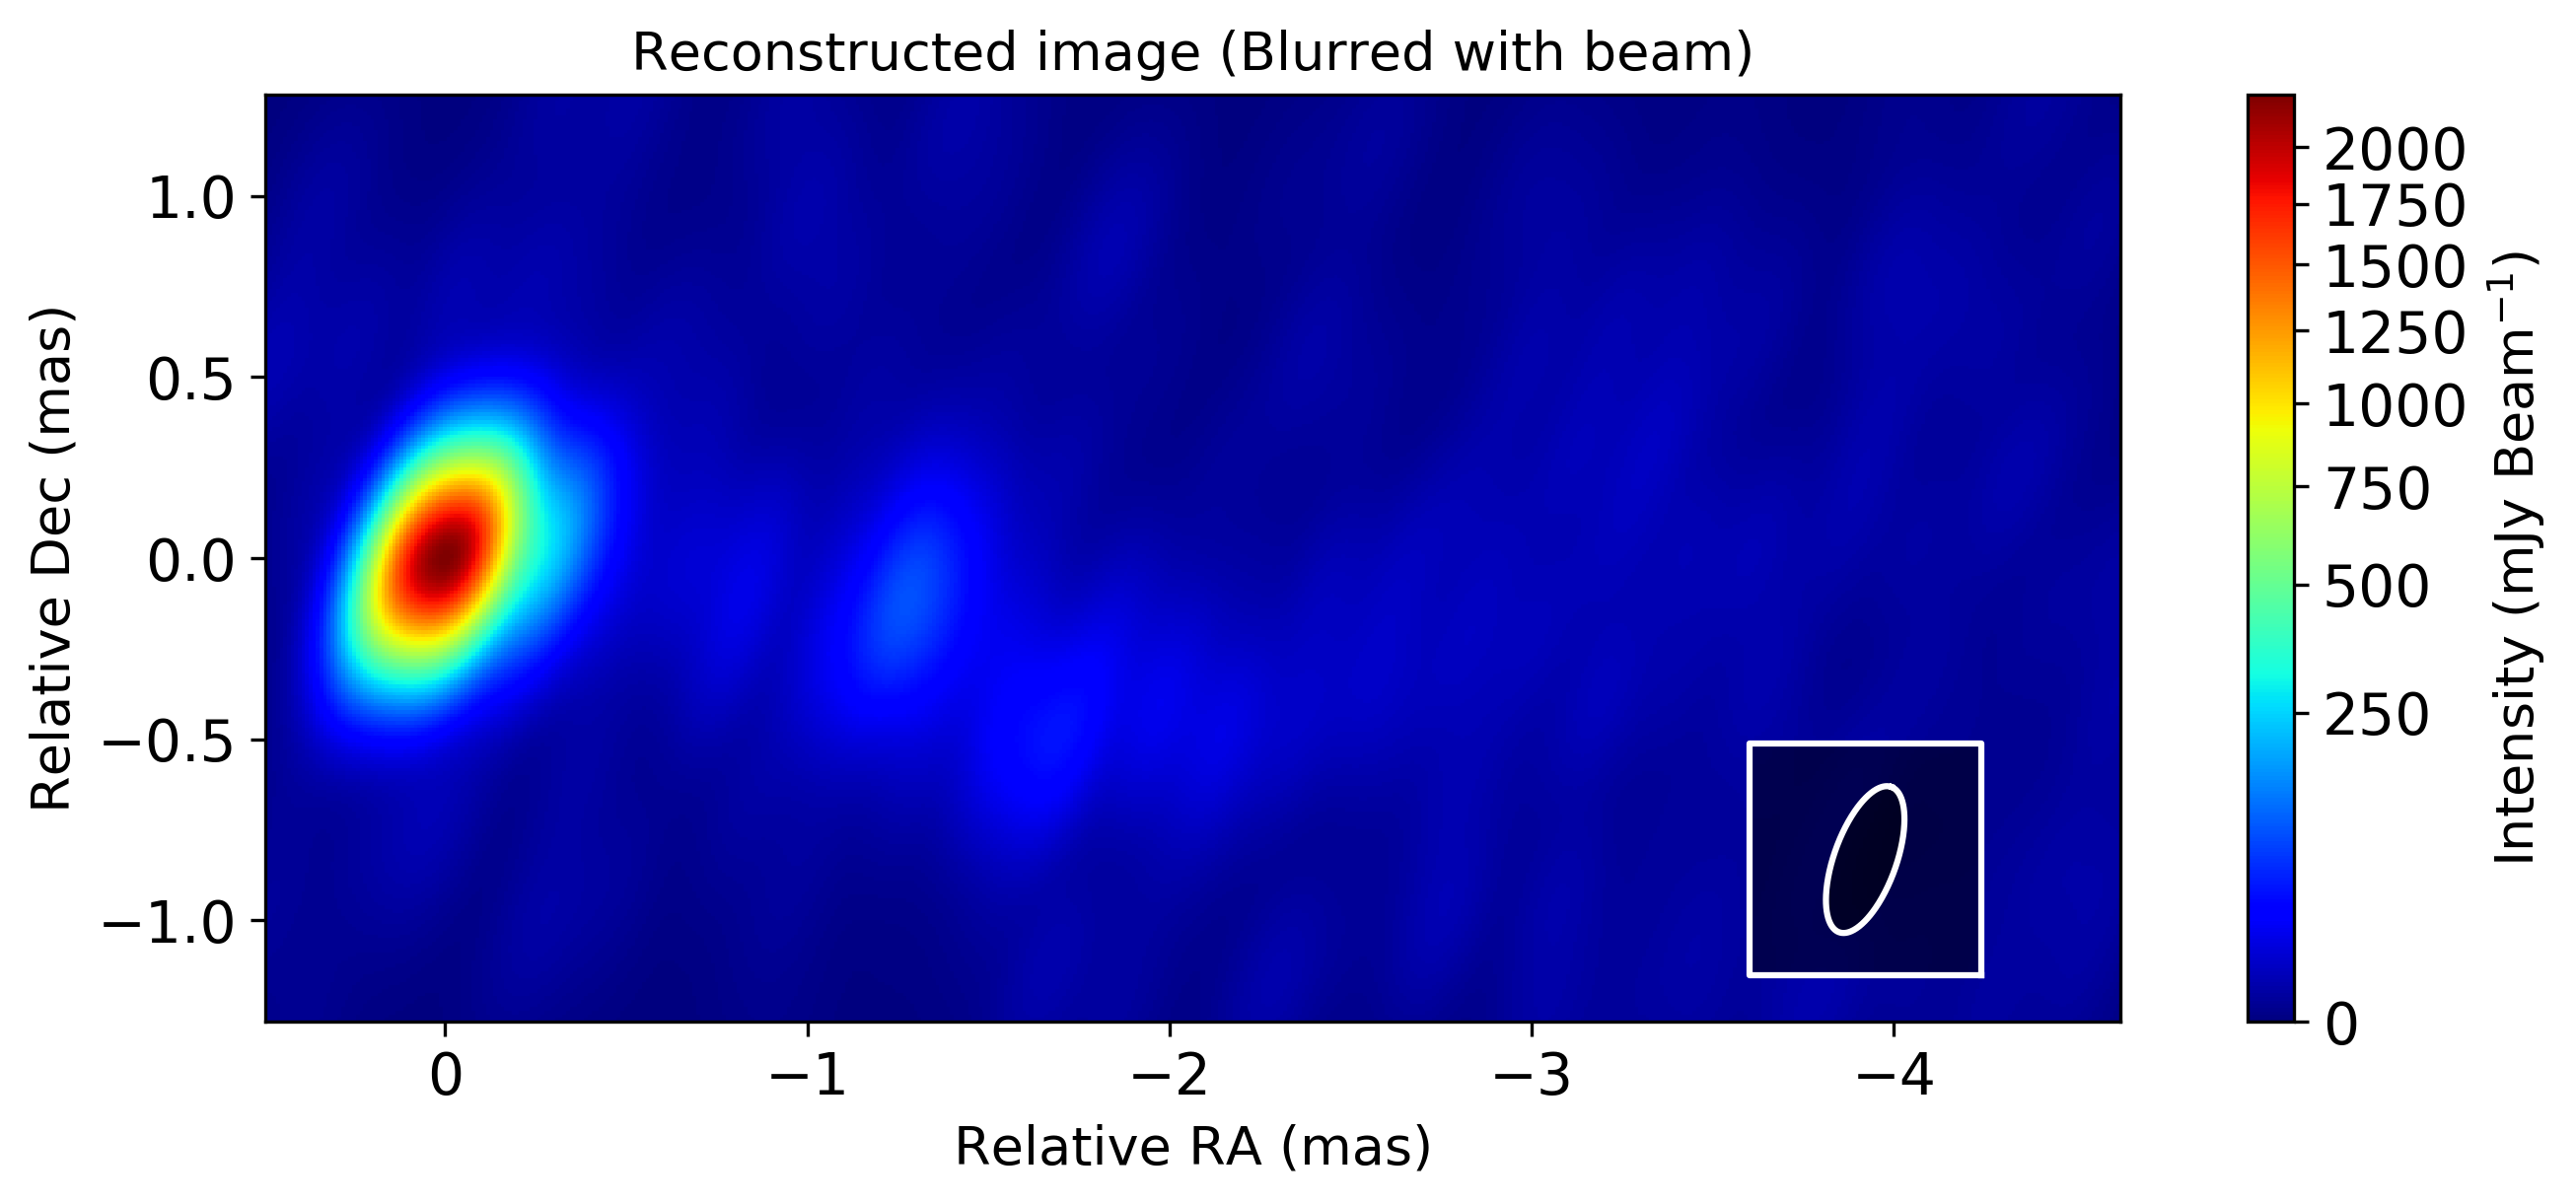

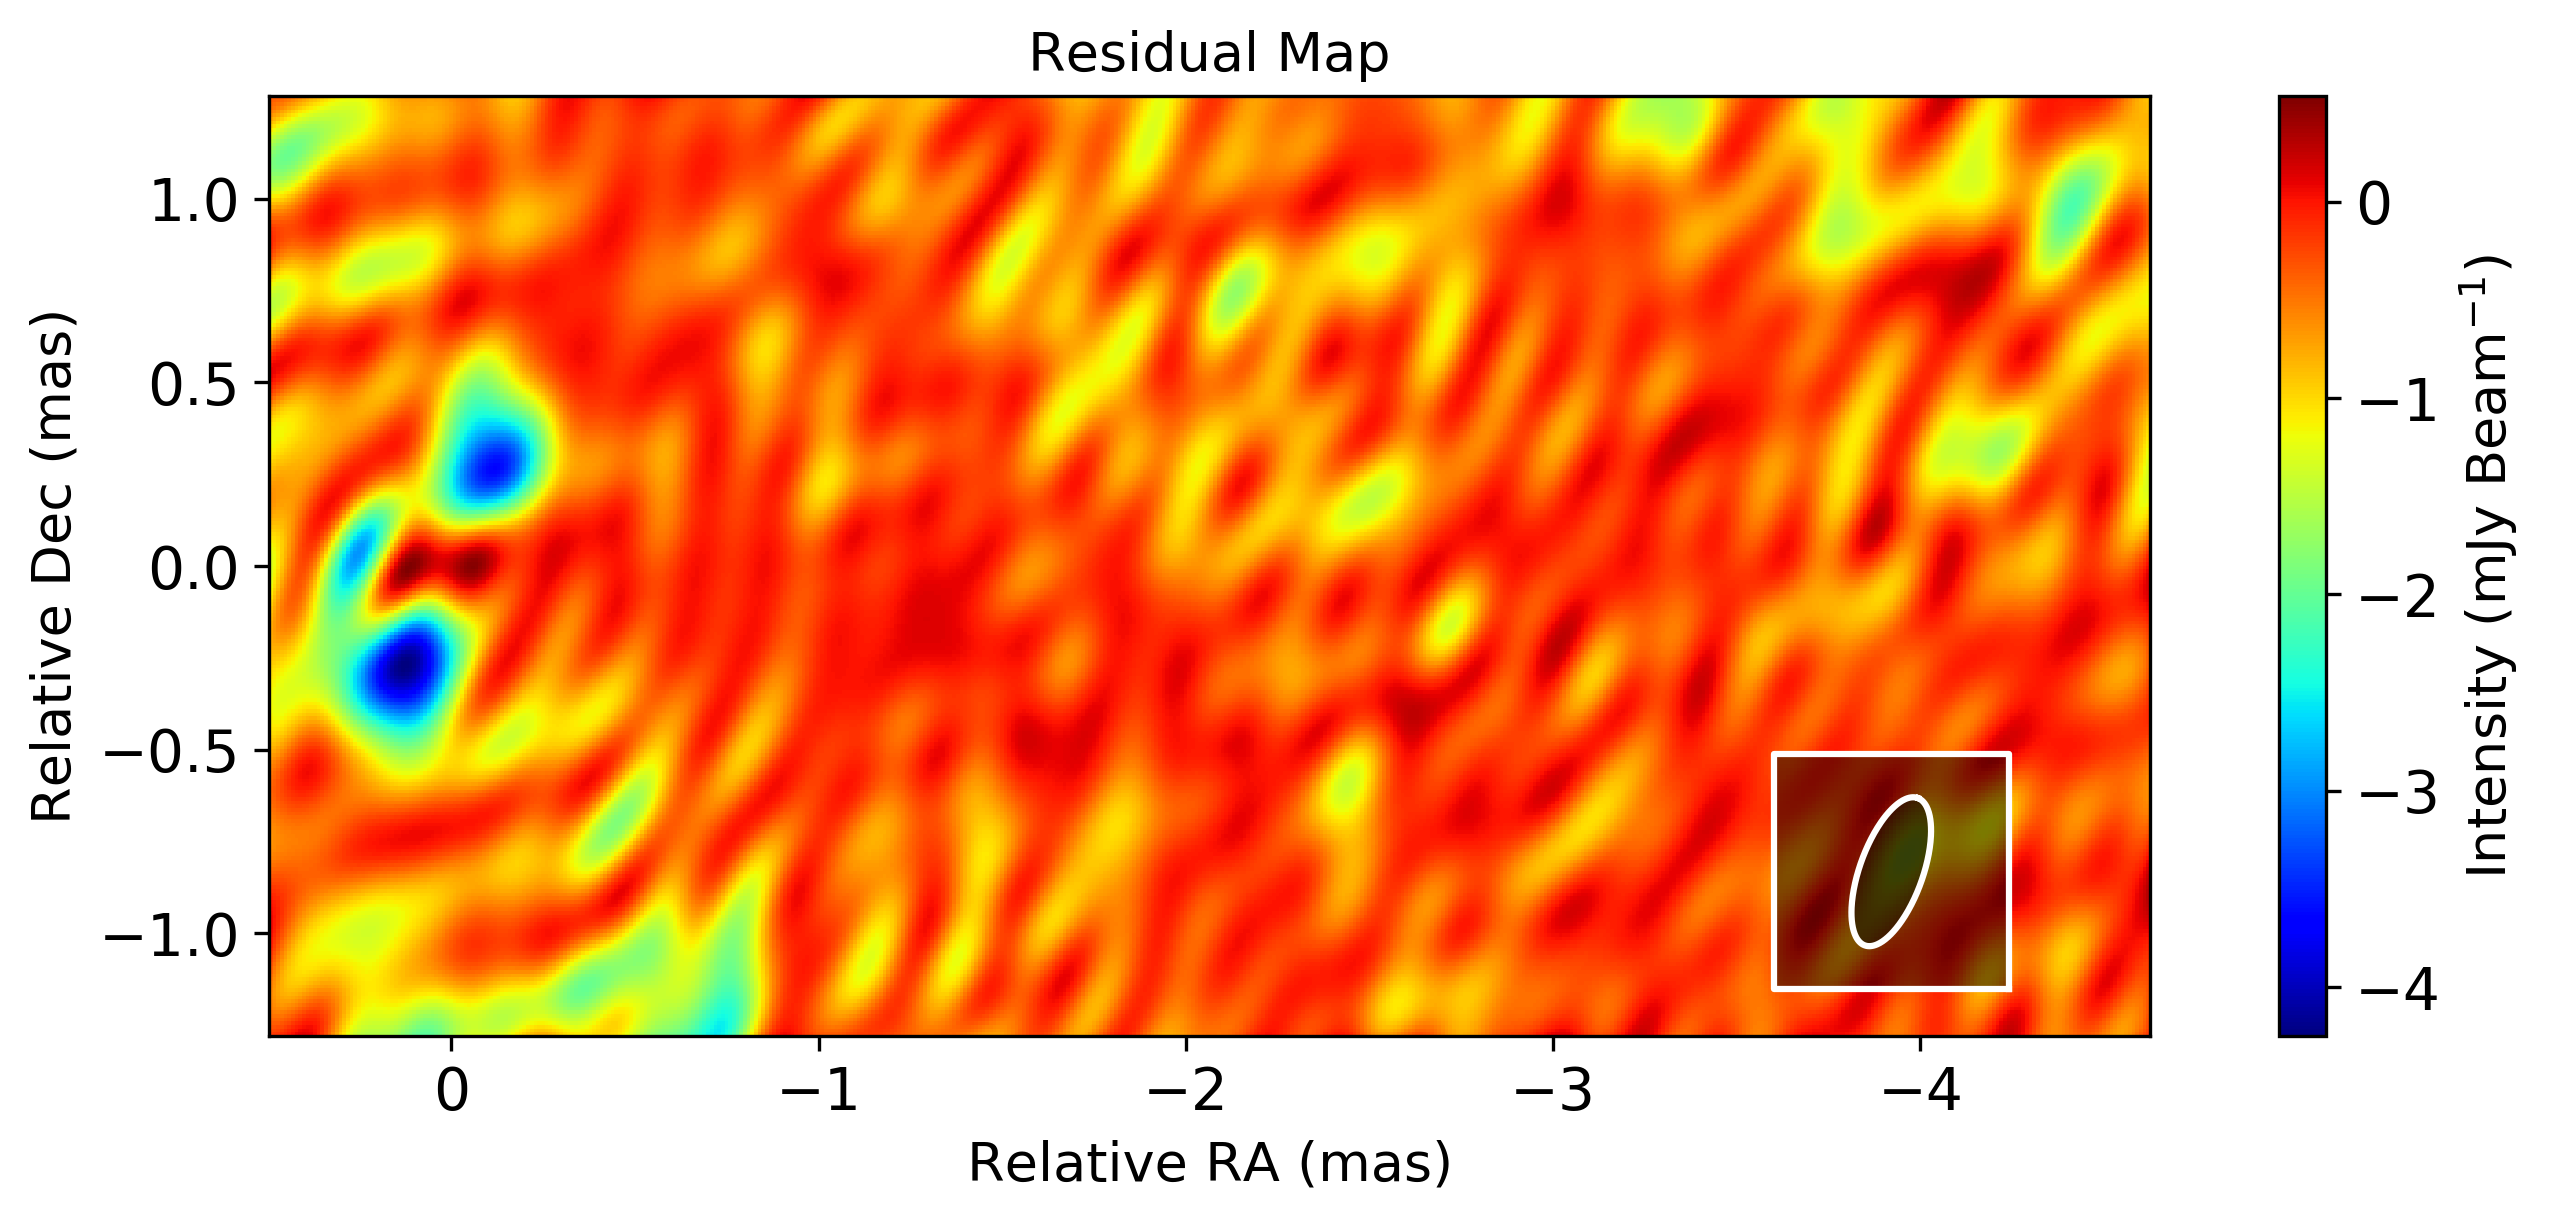

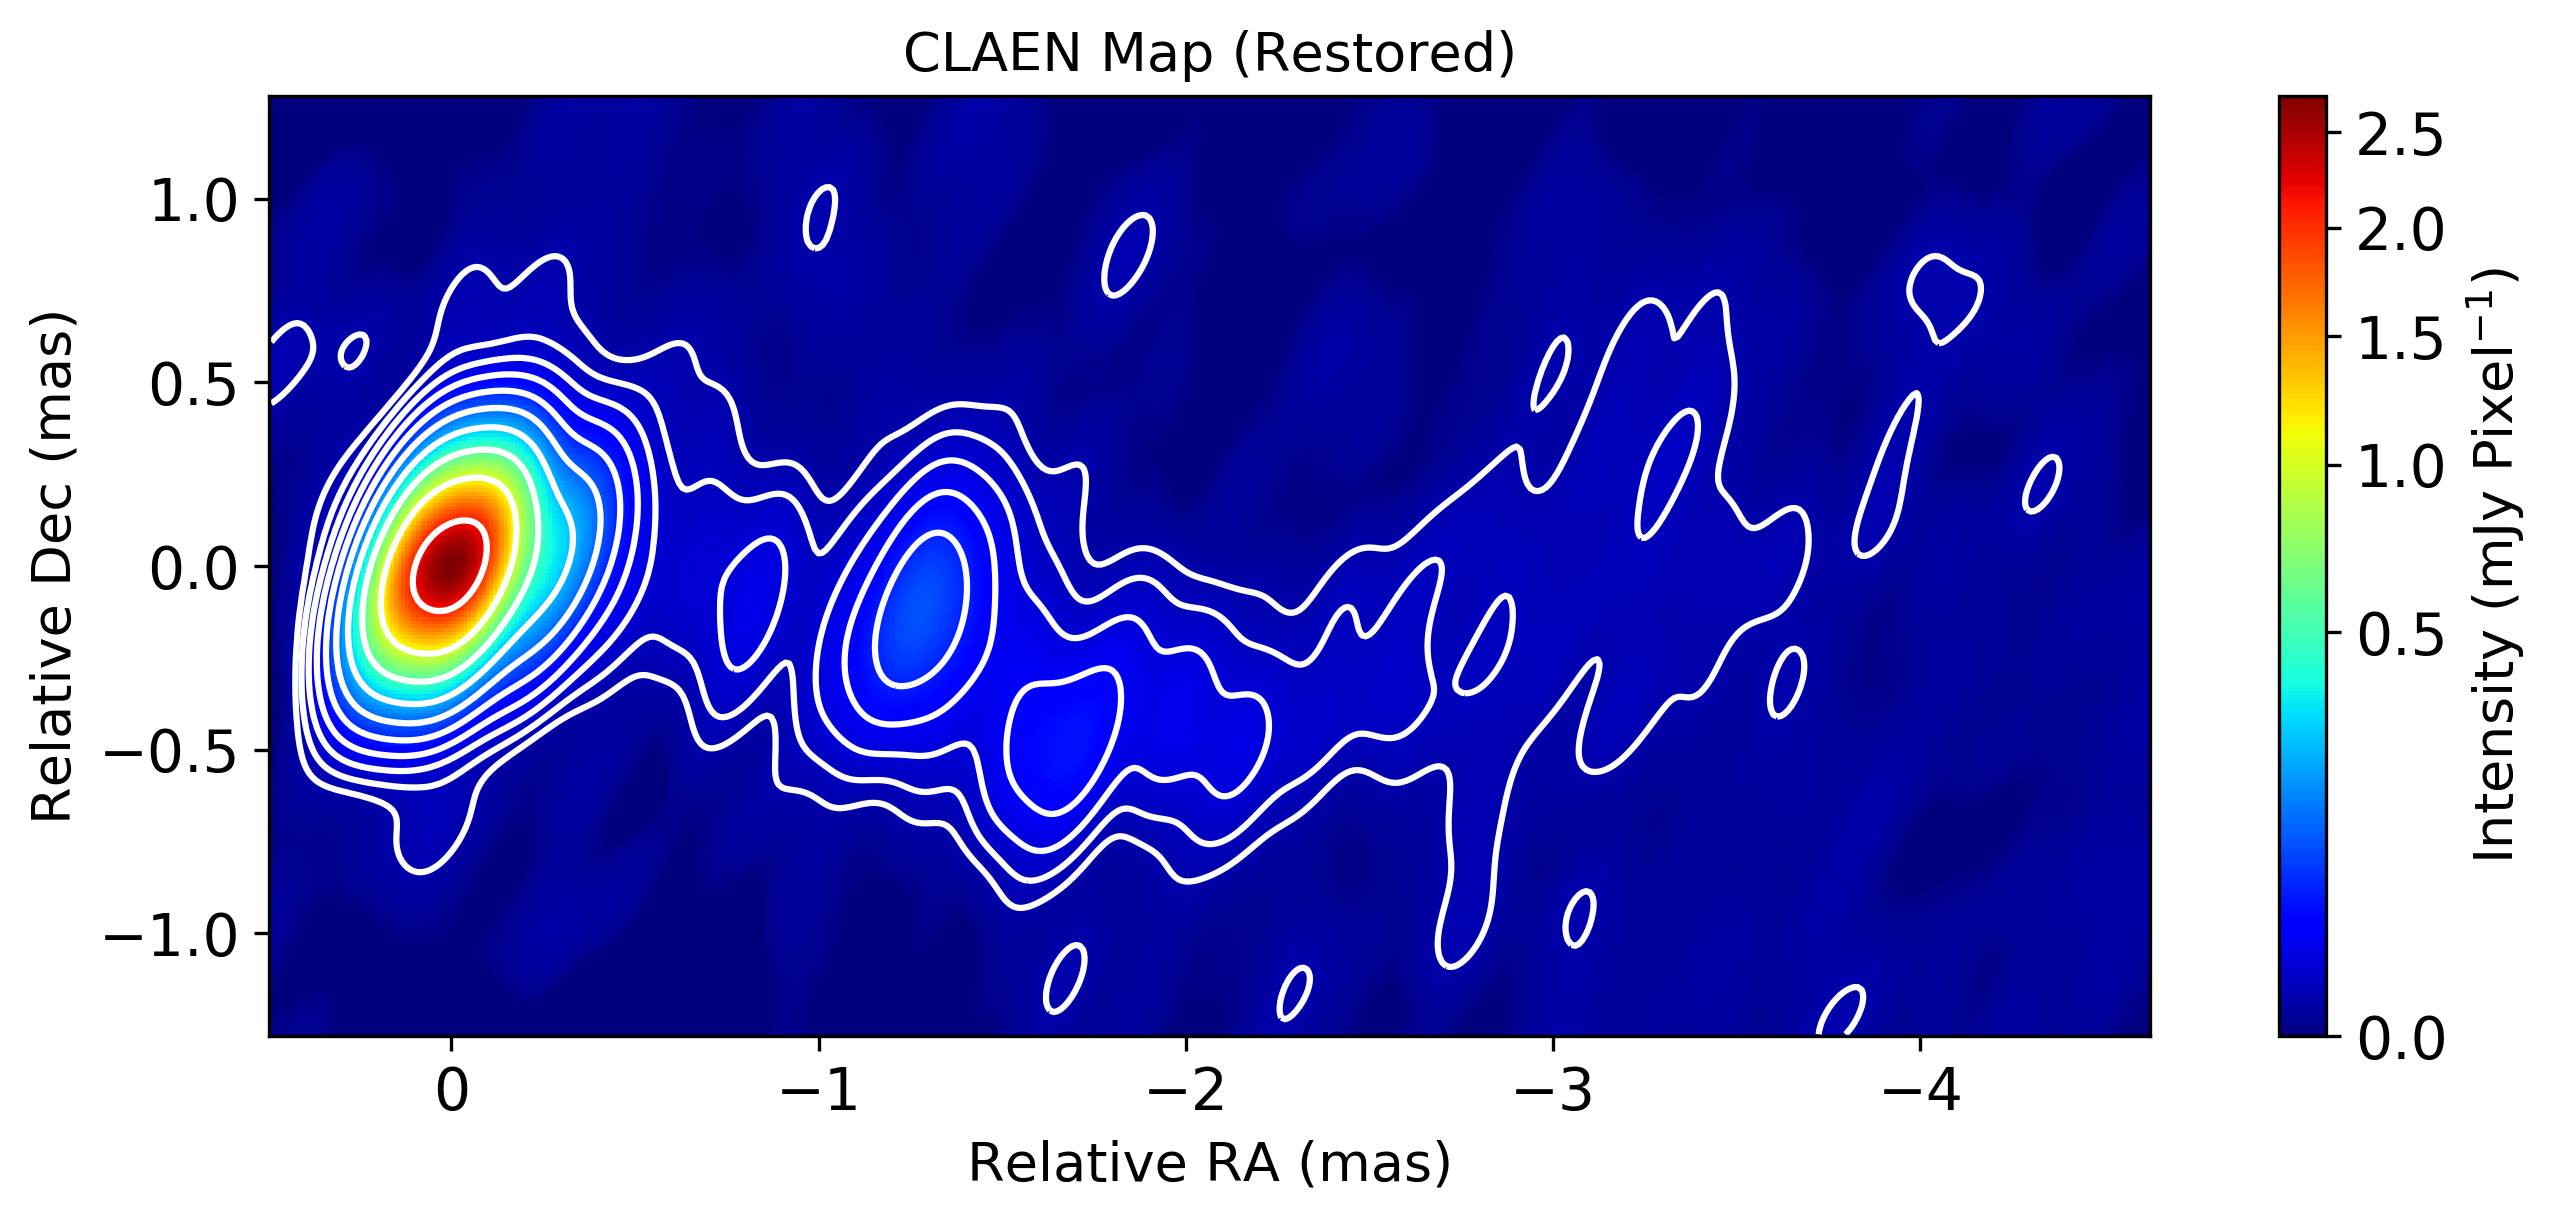

In [14]:
util.matplotlibrc(width=800, height=300)

plt.figure()
plt.title("Raw reconstructed image")
outimage.imshow(scale="gamma", colorbar=True, fluxunit="mjy", saunit="pixel", cmap=cm.jet)

plt.figure()
plt.title("Reconstructed image (Blurred with beam)")
outimage.convolve_gauss(**outimage.get_beam()).imshow(scale="gamma", colorbar=True, fluxunit="mjy", saunit="beam", cmap=cm.jet)
outimage.plot_beam(x0=0.8)

plt.figure()
plt.title("Residual Map")
resid = vtable.map_residual(outimage)
resid.imshow(colorbar=True,  fluxunit="mjy", saunit="beam", cmap=cm.jet)
outimage.plot_beam(x0=0.8)

plt.figure()
plt.title("CLAEN Map (Restored)")
clean = vtable.map_clean(outimage, restore=True, errorweight=-2)

# check dynamic range
rms = resid.rms(fluxunit="Jy", saunit="pixel")
peak = clean.peak(fluxunit="Jy", saunit="pixel")
dyrange = peak/rms

# plot
plt.title("CLAEN Map (Restored)")
clean.imshow(scale="gamma", colorbar=True, fluxunit="mjy", cmap=cm.jet)
clean.contour(cmul=5/dyrange, relative=True)